#### Heat map every 2 seconds (16 frames). Find 0.5 contour to remove noise. Find bounding regions of all these 0.5 contours from 2 second intervals

Only including long breath holds > 8s

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

import matplotlib.path as path

import pickle

from skimage import measure


import scipy.signal

from scipy.interpolate import interp1d

In [2]:
with open('Cine Pickles/patient_numbers.pickle', 'rb') as handle:
    pat_nums = pickle.load(handle)
    
with open('Cine Pickles/pat_num_2_frac_nums.pickle', 'rb') as handle:
    pat_num_2_frac_nums = pickle.load(handle)

In [3]:

def closest_angle(angle, angles_sorted):


    distances = abs(angle - angles_sorted)

    min_distance = np.min(distances)

    where = np.where( distances == min_distance )[0][0]

    closest_angle = angles_sorted[where]

    return closest_angle        



In [4]:
patient_numbers = []

patient_fraction_dicts = []

for pat_num in pat_nums:
    
    patient_numbers.append(pat_num)
    
    fraction_numbers = []
    
    fractions_angle_dicts = []

    for frac_num in range(1, pat_num_2_frac_nums[pat_num] + 1):
        
        
        fraction_numbers.append(frac_num)
        

        print( '------>    Patient: ' + str(pat_num) + ', Fraction: ' + str(frac_num))
        
        print('')
        
        
        cine_video_name = 'pat_' + str(pat_num) + '_frac_' + str(frac_num) + '.ogv'
        
        

        
        
        
        with open('Cine Pickles/' + cine_video_name + '/number_of_minutes.pickle', 'rb') as handle:
            number_of_minutes = pickle.load(handle)

        with open('Cine Pickles/' + cine_video_name + '/cine_res.pickle', 'rb') as handle:
            cine_res = pickle.load(handle)

        with open('Cine Pickles/' + cine_video_name + '/cine_fps.pickle', 'rb') as handle:
            cine_fps = pickle.load(handle)

        with open('Cine Pickles/' + cine_video_name + '/MR_res.pickle', 'rb') as handle:
            MR_res = pickle.load(handle)


        print('MR resolution: ' + str(MR_res) )
        
        print('')


        with open('Cine Pickles/' + cine_video_name + '/MR_pixel.pickle', 'rb') as handle:
            MR_pixel = pickle.load(handle)


        with open('Cine Pickles/MR_res_2_pixel_size.pickle', 'rb') as handle:
            MR_res_2_pixel_size = pickle.load(handle)


        pixel_size = MR_res_2_pixel_size[MR_res]


        print('Pixel size: ' + str(pixel_size))
        
        print('')




        with open('Cine Pickles/MR_res_2_min_resolve.pickle', 'rb') as handle:
            MR_res_2_min_resolve = pickle.load(handle)


        min_resolvable_distance = MR_res_2_min_resolve[MR_res]


        print('Minimum resolvable distance: ' +str(min_resolvable_distance) )
        
        print('')





        ##=====================================================
        
        
        
        

        
        with open('Cine Pickles/' + cine_video_name + '/Analysising Breath-holds/long_breath_hold_frames_split.pickle', 'rb') as handle:
            long_breath_hold_frames_split = pickle.load(handle)


        with open('Cine Pickles/' + cine_video_name + '/Analysising Breath-holds/long_breath_hold_confidences_split.pickle', 'rb') as handle:
            long_breath_hold_confidences_split = pickle.load(handle)



        number_of_breath_holds = len(long_breath_hold_frames_split)




        ###====================================================





        Frames_Target_Pixel_Coordinates = []


        for minute_number in np.arange(1, number_of_minutes + 2 ,2):

            with open('Cine Pickles/' + cine_video_name + '/minute ' + str(minute_number) + '/Frames_Target_Pixel_Coordinates.pickle', 'rb') as handle:
                this_min_Frames_Target_Pixel_Coordinates = pickle.load(handle)

            Frames_Target_Pixel_Coordinates += list(this_min_Frames_Target_Pixel_Coordinates)





        ##==============================================



        #Heat map for all 2 second intervals




        averaging_time = 2.5

        averaging_frames = int(cine_fps*averaging_time)


        interval_heat_maps = []

        interval_mean_target_contours = []

        interval_indexs = []

        total_number_of_averaging_time_intervals = 0

        breath_hold_numbers = []



        for breath_hold_number in range( 0 , number_of_breath_holds):

        #for breath_hold_number in [1,3]:

            breath_hold_frames = long_breath_hold_frames_split[ breath_hold_number ]

            #####

            breath_hold_confidences = long_breath_hold_confidences_split[breath_hold_number]

            ### confidence weigthing with a sigmoid (0.025 @ 75, 0.975 @ 95, 0.5 @ 85)

            breath_hold_confidences_sigmoid = 1/( 1 + np.exp( (85 - breath_hold_confidences)/2.75))


            #######

            breath_hold_duration = (1/cine_fps)*len(breath_hold_frames)

            #number_of_averaging_time_intervals = int( round( breath_hold_duration/averaging_time , 0 ) )


            number_of_averaging_time_intervals = int(np.floor( breath_hold_duration/averaging_time ))


            total_number_of_averaging_time_intervals += number_of_averaging_time_intervals

            ##### To colour the paths by breath-hold

            breath_hold_numbers.append([])


            interval_heat_maps.append([])

            interval_mean_target_contours.append([])

            interval_indexs.append([])


            for averaging_time_interval_index in range(0 , number_of_averaging_time_intervals ):

                #two_sec_interval_index = 0

                #print(two_sec_interval_index)

                interval_indexs[breath_hold_number].append(averaging_time_interval_index)

                interval_frames = breath_hold_frames[ averaging_frames*averaging_time_interval_index : averaging_frames*(averaging_time_interval_index + 1)]

                #############

                interval_confidences_sigmoid = breath_hold_confidences_sigmoid[ averaging_frames*averaging_time_interval_index : averaging_frames*(averaging_time_interval_index + 1)]

                ##############

                breath_hold_numbers[breath_hold_number].append(breath_hold_number)



                interval_heat_map = np.zeros((512, 512))

                total_confidence_sigmoid = 0

                frame_number = 0


                for frame in interval_frames:


                        array = np.zeros((512, 512))



                        frame_confidence_sigmoid = interval_confidences_sigmoid[frame_number]

                        frame_number += 1

                        total_confidence_sigmoid += frame_confidence_sigmoid


                        #frame = breath_hold_frames_split[breath_hold][0]

                        #print(frame)

                        for i in range(0, len(Frames_Target_Pixel_Coordinates[frame])):

                            array[ Frames_Target_Pixel_Coordinates[frame][i, 1] ,  Frames_Target_Pixel_Coordinates[frame][i, 0] ] = frame_confidence_sigmoid

                            # multiplied by sigmoid??


                        interval_heat_map += array


                #interval_heat_map = interval_heat_map/len(interval_frames)

                interval_heat_map = interval_heat_map/total_confidence_sigmoid

                interval_heat_maps[breath_hold_number].append(interval_heat_map)


                ######## Find a contour at 0.5

                interval_mean_target_contour = measure.find_contours(interval_heat_map, 0.5)

                interval_mean_target_contours[breath_hold_number].append(interval_mean_target_contour)





        #=========================================================================================



        #Make paths out of two second contours



        interval_mean_target_paths = []

        interval_numbers = []

        interval_number = 0

        #path_colours = []

        for breath_hold_number in range( 0 , number_of_breath_holds):

            for averaging_time_interval_index in interval_indexs[breath_hold_number]:

                interval_numbers.append(interval_number)

                interval_number += 1

                interval_mean_target_paths.append(path.Path( interval_mean_target_contours[breath_hold_number][averaging_time_interval_index][0]))

                #path_colours.append(colour_list[ breath_hold_number%10])






        ############################################################################



        #Create heatmap at minimum resolvable distance resolution



        cine_pixel_size = pixel_size

        #print(cine_pixel_size)




        ################### !!!!!!!!!!!!!!!!!!!!!

        res_limit_pixel_size = min_resolvable_distance

        #print(min_resolvable_distance)


        ##### Make heat map in resolution of minimum resolvable distance, but for comparison of data still use 1.5mm bin widths




        pixel_scaling = cine_pixel_size/res_limit_pixel_size

        #print(pixel_scaling)





        #Find max and min x and y values


        x_maxs = []

        x_mins = []

        y_maxs = []

        y_mins = []


        for breath_hold_number in range( 0 , number_of_breath_holds):

            for averaging_time_interval_index in interval_indexs[breath_hold_number]:

                #print(two_sec_interval_index)

                cont = interval_mean_target_contours[breath_hold_number][averaging_time_interval_index]

                x_maxs.append( np.max(cont[0][:,1]))

                x_mins.append( np.min(cont[0][:,1]))

                y_maxs.append( np.max(cont[0][:,0]))

                y_mins.append( np.min(cont[0][:,0]))


                #interval_mean_target_contours[breath_hold_number][averaging_time_interval_index][0]



        x_max = int( np.round( np.max(x_maxs) , 0 ) )

        x_min = int( np.round( np.min(x_mins) , 0 ) )

        y_max = int( np.round( np.max(y_maxs) , 0 ) )

        y_min = int( np.round( np.min(y_mins) , 0 ) )





        #interval_mean_target_paths =  [ path.Path(  interval_mean_target_contours[interval_index][0])  for interval_index in   interval_indexs ]

        #interval_mean_target_paths =  [ path.Path(  interval_mean_target_contours[interval_index][0])  for interval_index in  range( 0 , total_number_of_2_sec_intervals) ]

        interval_mean_target_paths = []

        interval_numbers = []

        interval_number = 0

        path_colours = []



        for breath_hold_number in range( 0 , number_of_breath_holds):

            for averaging_time_interval_index in interval_indexs[breath_hold_number]:

                #print('u')

                interval_numbers.append(interval_number)

                interval_number += 1

                interval_mean_target_paths.append(path.Path( interval_mean_target_contours[breath_hold_number][averaging_time_interval_index][0]*pixel_scaling))

                #path_colours.append(colour_list[ breath_hold_number%10])






        dimension_x_plus = int( round( 10 + (x_max*pixel_scaling) , 0)) 

        dimension_x_minus = int( round( -10 + (x_min*pixel_scaling) , 0)) 




        dimension_y_plus = int( round( 10 + (y_max*pixel_scaling) , 0)) 

        dimension_y_minus = int( round( -10 + (y_min*pixel_scaling) , 0))      



#         print(dimension_x_minus)
#         print(dimension_x_plus)
#         print(dimension_y_minus)
#         print(dimension_y_plus)




        heat_map = np.zeros( ( dimension_y_plus - dimension_y_minus , dimension_x_plus - dimension_x_minus))




        for row_num in range( dimension_y_minus , dimension_y_plus):

            for column_num in range( dimension_x_minus , dimension_x_plus):

                #print( [row_num, column_num])

                contains = 0

                point = [ [row_num , column_num]]


                for interval_path in interval_mean_target_paths:

                    contains_point = interval_path.contains_points(point, radius = 0)

                    contains += contains_point


                #print(contains) 




                heat_map[row_num - dimension_y_minus ,  column_num - dimension_x_minus ] = contains



        heat_map = heat_map/len(interval_mean_target_paths)
        
        
        
        
        ##==================================================================================
        
        #Adapted paths to heat map
        
        
        adapted_paths_to_heat_map = []


        for breath_hold_number in range( 0 , number_of_breath_holds):

            #print(breath_hold_number)


            for interval_index in interval_indexs[breath_hold_number]:

                #print(averaging_time_interval_index)


                cont = interval_mean_target_contours[breath_hold_number][interval_index]

                adapted_paths_to_heat_map.append( path.Path(  [ [cont[0][i,1]*pixel_scaling - dimension_x_minus, cont[0][i,0]*pixel_scaling - dimension_y_minus ]  for i in range(0 , len(cont[0])) ] ))



        #==========================
        
#         fig = plt.figure()

#         ax = fig.add_subplot(111)

#         ax.imshow(heat_map, cmap = 'gray')




        #############=====================================================


        #### Mean contour on heat map



        heat_map_mean_contour = measure.find_contours(heat_map, 0.5)


        heat_map_mean_contour_y_denoised = scipy.signal.savgol_filter(heat_map_mean_contour[0][:,0] , 3, 1, mode = 'wrap')

        heat_map_mean_contour_y_denoised = np.concatenate( (heat_map_mean_contour_y_denoised, np.array([heat_map_mean_contour_y_denoised[0]])))


        heat_map_mean_contour_x_denoised = scipy.signal.savgol_filter(heat_map_mean_contour[0][:,1] , 3, 1, mode = 'wrap')

        heat_map_mean_contour_x_denoised = np.concatenate( (heat_map_mean_contour_x_denoised, np.array([heat_map_mean_contour_x_denoised[0]])))



        heat_map_mean_contour = np.array([ [heat_map_mean_contour_x_denoised[i] , heat_map_mean_contour_y_denoised[i] ] for i in range(0, len(heat_map_mean_contour_x_denoised))])


#         ax.plot(heat_map_mean_contour_x_denoised , heat_map_mean_contour_y_denoised , color = 'tab:cyan' )#, marker = '.')


        # Interpolate this mean contour (more points = more angles)


        mean_cont_x, mean_cont_y = heat_map_mean_contour.T

        i = np.arange(len(heat_map_mean_contour[0::1]))

        interp_i = np.linspace(0, i.max(), 2 * i.max())

        xi = interp1d(i, mean_cont_x, kind='cubic')(interp_i)
        yi = interp1d(i, mean_cont_y, kind='cubic')(interp_i)


        heat_map_mean_contour = np.array( list(zip(xi , yi)))


        heat_map_mean_contour_x_denoised = np.array(xi)

        heat_map_mean_contour_y_denoised = np.array(yi)







        ####=============================================================== 

        # Add expanded contours by +-1.5, +-3 , +-4.5 mm, 

        #count how many time averaged contours are conatin within expanded contours, 
        #for all normal gradients around mean contour



        norm_scaling = 1.5/min_resolvable_distance



        normal_gradients = []

        angles = []


        contour_plus_1_pixel = []  #1.5mm

        intersects_plus_1_pixel = []



        contour_minus_1_pixel = []

        intersects_minus_1_pixel = []



        contour_plus_2_pixel = []  #3mm

        intersects_plus_2_pixel = []




        contour_minus_2_pixel = []

        intersects_minus_2_pixel = []





        contour_plus_3_pixel = []#4.5mm

        intersects_plus_3_pixel = []


        contour_minus_3_pixel = []

        intersects_minus_3_pixel = []




        number_of_paths = len(adapted_paths_to_heat_map)

        #print(number_of_paths)




        for point_number in range(0, len(heat_map_mean_contour) - 1):

            delta_x = (heat_map_mean_contour_x_denoised[point_number + 1] - heat_map_mean_contour_x_denoised[point_number] )

            # print(delta_x)

            delta_y = (heat_map_mean_contour_y_denoised[point_number + 1] - heat_map_mean_contour_y_denoised[point_number] )

            # print(delta_y)


            mid_point = 0.5*(  np.array( [ heat_map_mean_contour_x_denoised[point_number] , heat_map_mean_contour_y_denoised[point_number] ]) + np.array( [ heat_map_mean_contour_x_denoised[point_number +1] , heat_map_mean_contour_y_denoised[point_number + 1] ]))


            # plt.scatter(mid_point[0] , mid_point[1])


            normal_gradient = (   1/(delta_x**2 + delta_y**2)**0.5)*np.array([delta_y , -delta_x])

            normal_gradients.append(normal_gradient)


            ### Angle defined from vertical (from cranial direction)


            cos_angle =  ( - normal_gradient[1]) /( ( normal_gradient[0]**2 + normal_gradient[1]**2 )**0.5)

            angle = np.arccos(cos_angle)

            if ( normal_gradient[0]) < 0:

                angle = 2*np.pi - angle 

            angles.append(angle)


            # plt.scatter(mid_point[0] + normal_gradient[0] , mid_point[1] + normal_gradient[1])




            #############################################################



            contour_plus_1_pixel.append( [mid_point[0] + norm_scaling*normal_gradient[0] , mid_point[1] + norm_scaling*normal_gradient[1] ] )



            ###### Count how many contours/paths inbetween these


            normal_end_points = np.array( [ mid_point , mid_point + norm_scaling*1*normal_gradient])


            normal_seg_path = path.Path(normal_end_points)





            intersect = 0


            for interval_contour_path in adapted_paths_to_heat_map:

                intersect += normal_seg_path.intersects_path( interval_contour_path , filled=False)



            intersects_plus_1_pixel.append(intersect/number_of_paths)  





            #############################################################



            contour_minus_1_pixel.append( [mid_point[0] - norm_scaling*normal_gradient[0] , mid_point[1] - norm_scaling*normal_gradient[1] ] )



            ###### Count how many contours/paths inbetween these


            normal_end_points = np.array( [ mid_point , mid_point - norm_scaling*1*normal_gradient])


            normal_seg_path = path.Path(normal_end_points)





            intersect = 0


            for interval_contour_path in adapted_paths_to_heat_map:

                intersect += normal_seg_path.intersects_path( interval_contour_path, filled=False)



            intersects_minus_1_pixel.append(intersect/number_of_paths)  






            #############################################################



            contour_plus_2_pixel.append( [mid_point[0] + norm_scaling*2*normal_gradient[0] , mid_point[1] + norm_scaling*2*normal_gradient[1] ] )



            ###### Count how many contours/paths inbetween these


            normal_end_points = np.array( [ mid_point , mid_point + norm_scaling*2*normal_gradient])


            normal_seg_path = path.Path(normal_end_points)





            intersect = 0


            for interval_contour_path in adapted_paths_to_heat_map:

                intersect += normal_seg_path.intersects_path( interval_contour_path, filled=False)



            intersects_plus_2_pixel.append(intersect/number_of_paths)  




            #############################################################



            contour_minus_2_pixel.append( [mid_point[0] - norm_scaling*2*normal_gradient[0] , mid_point[1] - norm_scaling*2*normal_gradient[1] ] )



            ###### Count how many contours/paths inbetween these


            normal_end_points = np.array( [ mid_point , mid_point - norm_scaling*2*normal_gradient])


            normal_seg_path = path.Path(normal_end_points)





            intersect = 0


            for interval_contour_path in adapted_paths_to_heat_map:

                intersect += normal_seg_path.intersects_path( interval_contour_path, filled=False)



            intersects_minus_2_pixel.append(intersect/number_of_paths)  



            #############################################################



            contour_plus_3_pixel.append( [mid_point[0] + norm_scaling*3*normal_gradient[0] , mid_point[1] + norm_scaling*3*normal_gradient[1] ] )



            ###### Count how many contours/paths inbetween these


            normal_end_points = np.array( [ mid_point , mid_point + norm_scaling*3*normal_gradient])


            normal_seg_path = path.Path(normal_end_points)





            intersect = 0


            for interval_contour_path in adapted_paths_to_heat_map:

                intersect += normal_seg_path.intersects_path( interval_contour_path, filled=False)



            intersects_plus_3_pixel.append(intersect/number_of_paths)  




            #############################################################



            contour_minus_3_pixel.append( [mid_point[0] - norm_scaling*3*normal_gradient[0] , mid_point[1] - norm_scaling*3*normal_gradient[1] ] )



            ###### Count how many contours/paths inbetween these


            normal_end_points = np.array( [ mid_point , mid_point - norm_scaling*3*normal_gradient])


            normal_seg_path = path.Path(normal_end_points)





            intersect = 0


            for interval_contour_path in adapted_paths_to_heat_map:

                intersect += normal_seg_path.intersects_path( interval_contour_path, filled=False)



            intersects_minus_3_pixel.append(intersect/number_of_paths)















        contour_plus_1_pixel = np.array(contour_plus_1_pixel + [contour_plus_1_pixel[0]])

        contour_minus_1_pixel = np.array(contour_minus_1_pixel + [contour_minus_1_pixel[0]])


        contour_plus_2_pixel = np.array(contour_plus_2_pixel + [contour_plus_2_pixel[0]])

        contour_minus_2_pixel = np.array(contour_minus_2_pixel + [contour_minus_2_pixel[0]])



        contour_plus_3_pixel = np.array(contour_plus_3_pixel + [contour_plus_3_pixel[0]])

        contour_minus_3_pixel = np.array(contour_minus_3_pixel + [contour_minus_3_pixel[0]])








        within_1_pixel = np.array(intersects_minus_1_pixel) + np.array(intersects_plus_1_pixel)


        within_2_pixel = np.array(intersects_minus_2_pixel) + np.array(intersects_plus_2_pixel)


        within_3_pixel = np.array(intersects_minus_3_pixel) + np.array(intersects_plus_3_pixel)









#         plt.plot(contour_plus_1_pixel[:,0] , contour_plus_1_pixel[:,1] , color = 'tab:blue')

#         plt.plot(contour_minus_1_pixel[:,0] , contour_minus_1_pixel[:,1] , color = 'tab:blue' )



#         plt.plot(contour_plus_2_pixel[:,0] , contour_plus_2_pixel[:,1] , color = 'tab:orange')

#         plt.plot(contour_minus_2_pixel[:,0] , contour_minus_2_pixel[:,1] , color = 'tab:orange')



#         plt.plot(contour_plus_3_pixel[:,0] , contour_plus_3_pixel[:,1] , color = 'tab:purple')

#         plt.plot(contour_minus_3_pixel[:,0] , contour_minus_3_pixel[:,1] , color = 'tab:purple')




        ####================================================================




        #Find looking at specific angles





        angle_to_1_pixel = dict( zip(angles, within_1_pixel))

        angle_to_2_pixel = dict( zip(angles, within_2_pixel))

        angle_to_3_pixel = dict( zip(angles, within_3_pixel))



        angles_sorted = np.array(sorted(angles) )





        within_1_pixel_sorted = [ angle_to_1_pixel[angle] for angle in angles_sorted]

        within_2_pixel_sorted = [ angle_to_2_pixel[angle] for angle in angles_sorted]

        within_3_pixel_sorted = [ angle_to_3_pixel[angle] for angle in angles_sorted]


        #print(len(angles_sorted))



        # angles_sorted_smoothed = scipy.signal.savgol_filter(angles_sorted, 21 , 3, mode = 'interp')

        # within_1_pixel_sorted_smoothed = scipy.signal.savgol_filter( within_1_pixel_sorted ,21, 3, mode = 'wrap')

        # within_2_pixel_sorted_smoothed = scipy.signal.savgol_filter( within_2_pixel_sorted, 21, 3, mode = 'wrap')

        # within_3_pixel_sorted_smoothed = scipy.signal.savgol_filter( within_3_pixel_sorted , 21, 3, mode = 'wrap')


        #plt.figure()


        #plt.plot( angles_sorted_smoothed , within_2_pixel_sorted_smoothed )

        #plt.scatter(angles_sorted , within_1_pixel_sorted , alpha = 1)

        

        
        angles = []
        
        angles_projection_data = []


        for theta in [0 , 1/4 , 1/2 , 3/4 ]:
            
            
            projection_angle = theta*np.pi


            angles.append(theta)
            
            
            print('angle: ' + str(theta) + ' pi' )
            
            print('______________')
            
            print('')
            
            
            
            
            #Actually within 1.5, 3, 3.5, mm of median contour (1,2,3 pixels in 1.5mm res)

            total_within_1_pixel = 0

            total_within_2_pixel = 0

            total_within_3_pixel = 0



            for angle in [ projection_angle, (projection_angle + np.pi)%(2*np.pi)]:


                # angle = (projection_angle + np.pi)%(2*np.pi)

                #print(angle/np.pi)
                
                angle = closest_angle( angle , angles_sorted) 
    
                print( round( angle/np.pi , 2))


                local_angle_range = np.pi/16


                if (angle > local_angle_range ) & ( angle < 2*np.pi - local_angle_range):

                    indexs = np.where( ( angles_sorted < angle + local_angle_range) & (angles_sorted > angle - local_angle_range) )[0]


                if angle < local_angle_range:


                    indexs = list(np.where( (angles_sorted < angle + local_angle_range))[0] ) + list(  np.where(   (angles_sorted > 2*np.pi - local_angle_range + angle)  )[0])

                    indexs = np.array(indexs)


                if 2*np.pi - angle < local_angle_range:

                    indexs = list(  np.where(   angles_sorted  > angle - local_angle_range)[0] )  + list( np.where( angles_sorted < local_angle_range - (2*np.pi - angle))[0])

                    indexs = np.array(indexs)







                angle_within_1_pixel = np.mean( [within_1_pixel_sorted[index] for index in indexs])

                if angle_within_1_pixel > 1:

                    angle_within_1_pixel = 1                

                total_within_1_pixel += angle_within_1_pixel

                #print('within 1.5mm median: ' + str(   round(100*angle_within_1_pixel , 1) ) + ' %' )




                angle_within_2_pixel = np.mean( [within_2_pixel_sorted[index] for index in indexs])

                if angle_within_2_pixel > 1:

                    angle_within_2_pixel = 1                     
                
                total_within_2_pixel += angle_within_2_pixel

                #print('within 3mm median: ' + str(   round(100*angle_within_2_pixel , 1) ) + ' %' )



                angle_within_3_pixel = np.mean( [within_3_pixel_sorted[index] for index in indexs])

                if angle_within_3_pixel > 1:

                    angle_within_3_pixel = 1                 
                
                total_within_3_pixel += angle_within_3_pixel

                #print('within 4.5mm median: ' + str(   round(100*angle_within_3_pixel , 1) ) + ' %' )


            
            
            total_within_1_pixel = round(100*total_within_1_pixel/2, 1)
            
            total_within_2_pixel = round(100*total_within_2_pixel/2, 1)
            
            total_within_3_pixel = round(100*total_within_3_pixel/2, 1)
            
            
            
            print('within 1.5mm median: ' + str( total_within_1_pixel ) + ' %' )
            
            print('')
            
            
            print('within 3mm median: ' + str( total_within_2_pixel ) + ' %' )
            
            print('')
            
            
            print('within 4.5mm median: ' + str( total_within_3_pixel ) + ' %' )
            
            print('')
            
            
            angles_projection_data.append([ total_within_1_pixel , total_within_2_pixel , total_within_3_pixel])
                        
            

        angles_dict = dict(zip(angles , angles_projection_data))
        
        fractions_angle_dicts.append(angles_dict)
        
        print('_________________________________________')
    
        print('')
    
        
    fraction_data_dict = dict( zip( fraction_numbers , fractions_angle_dicts) )
    
    patient_fraction_dicts.append(fraction_data_dict)


patient_data_dict = dict(  zip( patient_numbers , patient_fraction_dicts))    

------>    Patient: 1, Fraction: 1

MR resolution: 100

Pixel size: 0.79

Minimum resolvable distance: 1.5

angle: 0 pi
______________

0.0
0.98
within 1.5mm median: 66.5 %

within 3mm median: 96.8 %

within 4.5mm median: 100.0 %

angle: 0.25 pi
______________

0.25
1.24
within 1.5mm median: 96.5 %

within 3mm median: 100.0 %

within 4.5mm median: 100.0 %

angle: 0.5 pi
______________

0.5
1.49
within 1.5mm median: 90.6 %

within 3mm median: 99.1 %

within 4.5mm median: 100.0 %

angle: 0.75 pi
______________

0.77
1.74
within 1.5mm median: 75.0 %

within 3mm median: 99.4 %

within 4.5mm median: 100.0 %

_________________________________________

------>    Patient: 1, Fraction: 2

MR resolution: 100

Pixel size: 0.79

Minimum resolvable distance: 1.5

angle: 0 pi
______________

0.01
1.01
within 1.5mm median: 52.8 %

within 3mm median: 84.9 %

within 4.5mm median: 92.4 %

angle: 0.25 pi
______________

0.24
1.25
within 1.5mm median: 83.8 %

within 3mm median: 95.8 %

within 4.5mm media

angle: 0 pi
______________

0.01
1.01
within 1.5mm median: 70.5 %

within 3mm median: 96.3 %

within 4.5mm median: 98.7 %

angle: 0.25 pi
______________

0.26
1.25
within 1.5mm median: 90.4 %

within 3mm median: 98.6 %

within 4.5mm median: 99.0 %

angle: 0.5 pi
______________

0.5
1.49
within 1.5mm median: 93.2 %

within 3mm median: 99.0 %

within 4.5mm median: 99.1 %

angle: 0.75 pi
______________

0.75
1.75
within 1.5mm median: 78.0 %

within 3mm median: 96.3 %

within 4.5mm median: 99.1 %

_________________________________________

------>    Patient: 4, Fraction: 1

MR resolution: 112

Pixel size: 0.6

Minimum resolvable distance: 1.5

angle: 0 pi
______________

0.0
1.0
within 1.5mm median: 72.6 %

within 3mm median: 85.8 %

within 4.5mm median: 92.2 %

angle: 0.25 pi
______________

0.25
1.26
within 1.5mm median: 79.7 %

within 3mm median: 94.1 %

within 4.5mm median: 95.7 %

angle: 0.5 pi
______________

0.49
1.49
within 1.5mm median: 79.8 %

within 3mm median: 96.5 %

within 4

angle: 0 pi
______________

0.05
1.0
within 1.5mm median: 93.2 %

within 3mm median: 100.0 %

within 4.5mm median: 100.0 %

angle: 0.25 pi
______________

0.25
1.25
within 1.5mm median: 98.1 %

within 3mm median: 100.0 %

within 4.5mm median: 100.0 %

angle: 0.5 pi
______________

0.5
1.5
within 1.5mm median: 98.1 %

within 3mm median: 100.0 %

within 4.5mm median: 100.0 %

angle: 0.75 pi
______________

0.75
1.75
within 1.5mm median: 90.3 %

within 3mm median: 99.7 %

within 4.5mm median: 100.0 %

_________________________________________

------>    Patient: 6, Fraction: 1

MR resolution: 100

Pixel size: 0.79

Minimum resolvable distance: 1.5

angle: 0 pi
______________

0.0
1.0
within 1.5mm median: 57.8 %

within 3mm median: 85.0 %

within 4.5mm median: 92.7 %

angle: 0.25 pi
______________

0.24
1.24
within 1.5mm median: 65.3 %

within 3mm median: 83.1 %

within 4.5mm median: 87.3 %

angle: 0.5 pi
______________

0.5
1.5
within 1.5mm median: 69.9 %

within 3mm median: 86.8 %

with

angle: 0 pi
______________

0.06
0.99
within 1.5mm median: 75.4 %

within 3mm median: 96.8 %

within 4.5mm median: 97.7 %

angle: 0.25 pi
______________

0.27
1.23
within 1.5mm median: 76.7 %

within 3mm median: 98.4 %

within 4.5mm median: 98.8 %

angle: 0.5 pi
______________

0.51
1.49
within 1.5mm median: 56.5 %

within 3mm median: 92.2 %

within 4.5mm median: 98.8 %

angle: 0.75 pi
______________

0.79
1.75
within 1.5mm median: 65.3 %

within 3mm median: 90.7 %

within 4.5mm median: 97.7 %

_________________________________________

------>    Patient: 8, Fraction: 5

MR resolution: 112

Pixel size: 0.6

Minimum resolvable distance: 1.5

angle: 0 pi
______________

0.01
1.01
within 1.5mm median: 77.7 %

within 3mm median: 96.7 %

within 4.5mm median: 100.0 %

angle: 0.25 pi
______________

0.25
1.24
within 1.5mm median: 69.4 %

within 3mm median: 96.5 %

within 4.5mm median: 99.9 %

angle: 0.5 pi
______________

0.5
1.5
within 1.5mm median: 73.6 %

within 3mm median: 97.6 %

within

angle: 0 pi
______________

0.0
1.0
within 1.5mm median: 69.1 %

within 3mm median: 89.9 %

within 4.5mm median: 96.1 %

angle: 0.25 pi
______________

0.26
1.24
within 1.5mm median: 85.5 %

within 3mm median: 98.1 %

within 4.5mm median: 99.2 %

angle: 0.5 pi
______________

0.5
1.49
within 1.5mm median: 92.3 %

within 3mm median: 98.6 %

within 4.5mm median: 99.2 %

angle: 0.75 pi
______________

0.74
1.75
within 1.5mm median: 74.4 %

within 3mm median: 91.4 %

within 4.5mm median: 97.3 %

_________________________________________

------>    Patient: 12, Fraction: 3

MR resolution: 144

Pixel size: 0.81

Minimum resolvable distance: 1.5

angle: 0 pi
______________

0.04
1.01
within 1.5mm median: 62.9 %

within 3mm median: 90.9 %

within 4.5mm median: 98.9 %

angle: 0.25 pi
______________

0.25
1.25
within 1.5mm median: 86.4 %

within 3mm median: 98.6 %

within 4.5mm median: 99.5 %

angle: 0.5 pi
______________

0.5
1.5
within 1.5mm median: 91.7 %

within 3mm median: 99.1 %

within 4

#### Save full data as pickle - load into new script and box plot with centroid data

In [5]:
with open('Cine Pickles/boundary_variation_data_(mean).pickle', 'wb') as handle:
    pickle.dump(patient_data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
within_1_5_unravelled = []

within_3_unravelled = []

within_4_5_unravelled = []

angle = 0

for pat_num in pat_nums:
    
    for frac_num in range(1, pat_num_2_frac_nums[pat_num] + 1):

            
            percentage_1_5 = patient_data_dict[pat_num][frac_num][angle][0]
            
            percentage_3 = patient_data_dict[pat_num][frac_num][angle][1]
            
            percentage_4_5 = patient_data_dict[pat_num][frac_num][angle][2]
            
            #print(percentage)
            
            within_1_5_unravelled.append( percentage_1_5)
            
            within_3_unravelled.append( percentage_3)
            
            within_4_5_unravelled.append( percentage_4_5)
            
 



print(len(within_1_5_unravelled))

56


<IPython.core.display.Javascript object>


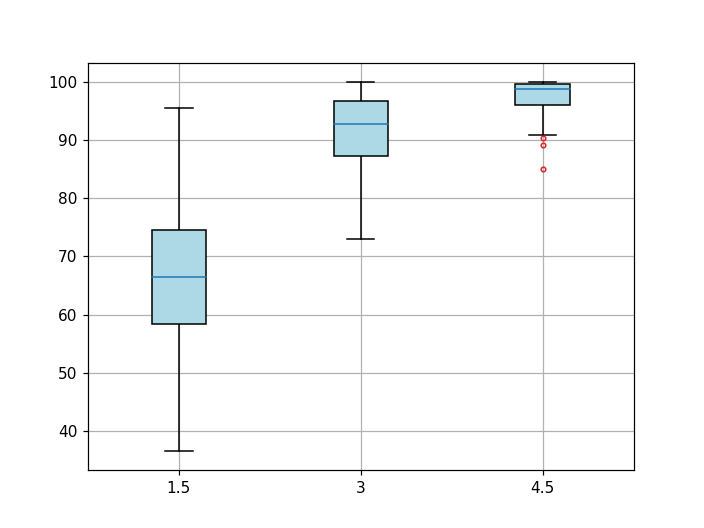

In [7]:
plt.figure()

plt.grid()

bp = plt.boxplot( [ within_1_5_unravelled , within_3_unravelled, within_4_5_unravelled ] ,
                 positions = [1, 2,3],
            patch_artist = 'True' , 
            labels = [ 1.5, 3, 4.5],
           boxprops=dict(fc='lightblue', color='black'),
            medianprops=dict(color='tab:blue'),
            flierprops=dict(color='tab:red', marker = '.', markeredgecolor='tab:red')
           
        )


# bp = plt.boxplot( [ within_3_unravelled , within_4_5_unravelled ] ,
#                  positions = [1.5, 3.5],
#             patch_artist = 'True' , 
#             labels = [ 6, 3],
#            boxprops=dict(fc='orange', color='black'),
#             medianprops=dict(color='tab:blue'),
#             flierprops=dict(color='tab:red', marker = '.', markeredgecolor='tab:red')
           
#         )


#plt.legend([bp['boxes'][0:2][0], bp['boxes'][2]] , ['one', 'two'])






In [139]:
cine_video_name = 'pat_4_frac_3.ogv'

#cine_video_name = 'ZZZZZ, Modus4D  - Fraction3 - 1.ogv'

#cine_video_name = 'Cine Treatment 1.ogv'

with open('Cine Pickles/' + cine_video_name + '/number_of_minutes.pickle', 'rb') as handle:
    number_of_minutes = pickle.load(handle)

with open('Cine Pickles/' + cine_video_name + '/cine_res.pickle', 'rb') as handle:
    cine_res = pickle.load(handle)
    
with open('Cine Pickles/' + cine_video_name + '/cine_fps.pickle', 'rb') as handle:
    cine_fps = pickle.load(handle)
    
with open('Cine Pickles/' + cine_video_name + '/MR_res.pickle', 'rb') as handle:
    MR_res = pickle.load(handle)
    
    
print('MR resolution: ' + str(MR_res) )

    
with open('Cine Pickles/' + cine_video_name + '/MR_pixel.pickle', 'rb') as handle:
    MR_pixel = pickle.load(handle)

    
with open('Cine Pickles/MR_res_2_pixel_size.pickle', 'rb') as handle:
    MR_res_2_pixel_size = pickle.load(handle)
    

pixel_size = MR_res_2_pixel_size[MR_res]


print('Pixel size: ' + str(pixel_size))



    
with open('Cine Pickles/MR_res_2_min_resolve.pickle', 'rb') as handle:
    MR_res_2_min_resolve = pickle.load(handle)
    

min_resolvable_distance = MR_res_2_min_resolve[MR_res]


print('Minimum resolvable distance: ' +str(min_resolvable_distance) )

MR resolution: 112
Pixel size: 0.56
Minimum resolvable distance: 1.1


In [140]:
with open('Cine Pickles/' + cine_video_name + '/Analysising Breath-holds/long_breath_hold_frames_split.pickle', 'rb') as handle:
    long_breath_hold_frames_split = pickle.load(handle)
    
    
with open('Cine Pickles/' + cine_video_name + '/Analysising Breath-holds/long_breath_hold_confidences_split.pickle', 'rb') as handle:
    long_breath_hold_confidences_split = pickle.load(handle)

    
    
number_of_breath_holds = len(long_breath_hold_frames_split)


print(number_of_breath_holds)

19


In [141]:
Frames_Target_Pixel_Coordinates = []


for minute_number in np.arange(1, number_of_minutes + 2 ,2):
    
    with open('Cine Pickles/' + cine_video_name + '/minute ' + str(minute_number) + '/Frames_Target_Pixel_Coordinates.pickle', 'rb') as handle:
        this_min_Frames_Target_Pixel_Coordinates = pickle.load(handle)
        
    Frames_Target_Pixel_Coordinates += list(this_min_Frames_Target_Pixel_Coordinates)

#### Heat Map for first 2 seconds

In [142]:
# breath_hold_number = 8

# breath_hold_frames = long_breath_hold_frames_split[ breath_hold_number ]

# breath_hold_duration = (1/8)*len(breath_hold_frames)

# number_of_2_sec_intervals = int( round( breath_hold_duration/2 , 0 ) )


#### Heat map for all 2 second intervals

Find contour at 0.5 to remove contouring noise

In [143]:
averaging_time = 2

averaging_frames = cine_fps*averaging_time


interval_heat_maps = []

interval_mean_target_contours = []

interval_indexs = []

total_number_of_averaging_time_intervals = 0

breath_hold_numbers = []



for breath_hold_number in range( 0 , number_of_breath_holds):
    
#for breath_hold_number in [1,3]:

    breath_hold_frames = long_breath_hold_frames_split[ breath_hold_number ]
    
    #####
    
    breath_hold_confidences = long_breath_hold_confidences_split[breath_hold_number]
    
    ### confidence weigthing with a sigmoid (0.025 @ 75, 0.975 @ 95, 0.5 @ 85)
    
    breath_hold_confidences_sigmoid = 1/( 1 + np.exp( (85 - breath_hold_confidences)/2.75))
    
    
    #######

    breath_hold_duration = (1/cine_fps)*len(breath_hold_frames)

    number_of_averaging_time_intervals = int( round( breath_hold_duration/averaging_time , 0 ) )
    
    total_number_of_averaging_time_intervals += number_of_averaging_time_intervals
    
    ##### To colour the paths by breath-hold
    
    breath_hold_numbers.append([])
    
    
    interval_heat_maps.append([])

    interval_mean_target_contours.append([])

    interval_indexs.append([])


    for averaging_time_interval_index in range(0 , number_of_averaging_time_intervals ):

        #two_sec_interval_index = 0
        
        #print(two_sec_interval_index)

        interval_indexs[breath_hold_number].append(averaging_time_interval_index)

        interval_frames = breath_hold_frames[ averaging_time*cine_fps*averaging_time_interval_index : averaging_time*cine_fps*(averaging_time_interval_index + 1)]
        
        #############
        
        interval_confidences_sigmoid = breath_hold_confidences_sigmoid[ averaging_time*cine_fps*averaging_time_interval_index : averaging_time*cine_fps*(averaging_time_interval_index + 1)]
        
        ##############
        
        breath_hold_numbers[breath_hold_number].append(breath_hold_number)



        interval_heat_map = np.zeros((512, 512))
        
        total_confidence_sigmoid = 0
        
        frame_number = 0


        for frame in interval_frames:


                array = np.zeros((512, 512))
                
                
                
                frame_confidence_sigmoid = interval_confidences_sigmoid[frame_number]
                
                frame_number += 1
                
                total_confidence_sigmoid += frame_confidence_sigmoid


                #frame = breath_hold_frames_split[breath_hold][0]

                #print(frame)

                for i in range(0, len(Frames_Target_Pixel_Coordinates[frame])):

                    array[ Frames_Target_Pixel_Coordinates[frame][i, 1] ,  Frames_Target_Pixel_Coordinates[frame][i, 0] ] = frame_confidence_sigmoid
                    
                    # multiplied by sigmoid??


                interval_heat_map += array


        #interval_heat_map = interval_heat_map/len(interval_frames)
        
        interval_heat_map = interval_heat_map/total_confidence_sigmoid

        interval_heat_maps[breath_hold_number].append(interval_heat_map)


        ######## Find a contour at 0.5

        interval_mean_target_contour = measure.find_contours(interval_heat_map, 0.5)

        interval_mean_target_contours[breath_hold_number].append(interval_mean_target_contour)



16


<IPython.core.display.Javascript object>


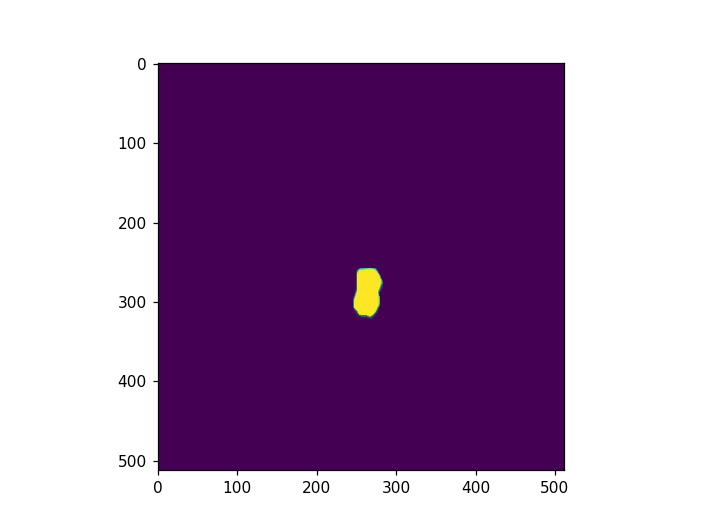

In [144]:
print(len(interval_indexs[4]))

plt.figure()

plt.imshow(interval_heat_maps[4][1])

<IPython.core.display.Javascript object>


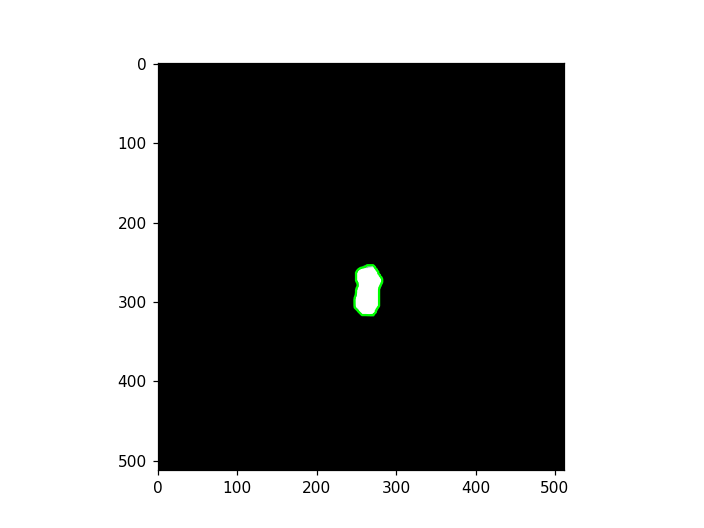

In [145]:
breath_hold_number = 2

interval_number = 2

plt.figure()


plt.imshow(interval_heat_maps[breath_hold_number][interval_number] , cmap = 'bone')

interval_mean_target_contour = measure.find_contours(interval_heat_maps[breath_hold_number][interval_number], 0.5)


plt.plot(interval_mean_target_contour[0][:,1] , interval_mean_target_contour[0][:,0] , color = 'lime')
#print(interval_mean_target_contour)


<IPython.core.display.Javascript object>


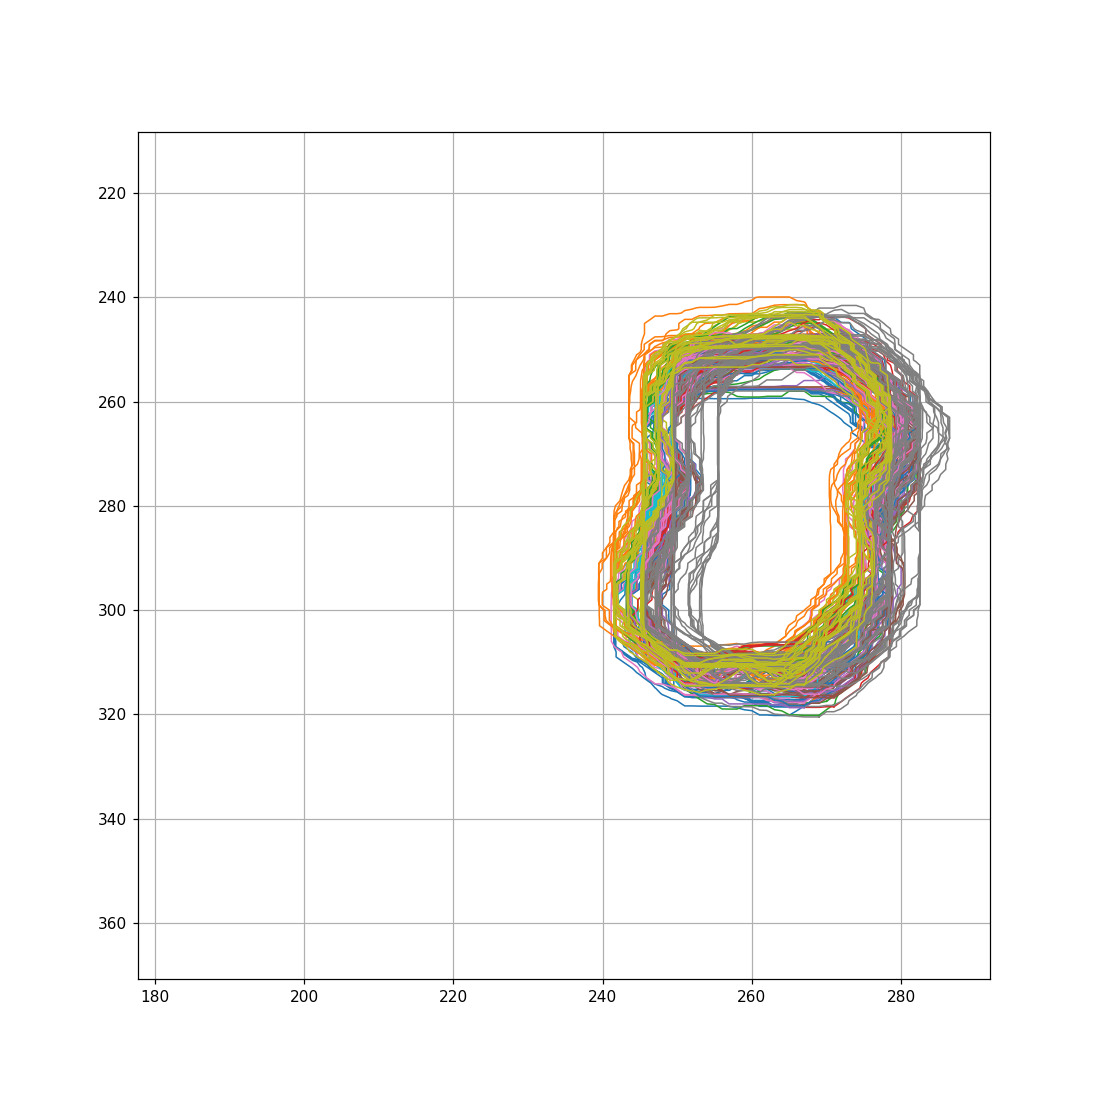

In [146]:
plt.figure(figsize = (10,10))


#plt.imshow( interval_heat_maps[6] , cmap = 'bone')

plt.grid()

plt.gca().invert_yaxis()

colour_list = ['tab:blue' , 'tab:orange' , 'tab:green' , 'tab:red' , 'tab:purple' , 'tab:brown'
             , 'tab:pink' , 'tab:gray' , 'tab:olive' , 'tab:cyan']



    
for breath_hold_number in range( 0 , number_of_breath_holds):


    
    
    
    for averaging_time_interval_index in interval_indexs[breath_hold_number]:

        #print(two_sec_interval_index)

        cont = interval_mean_target_contours[breath_hold_number][averaging_time_interval_index]

        plt.plot(cont[0][:,1], cont[0][:,0],  linewidth =1 , color = colour_list[ breath_hold_number%10] )
    
#plt.legend([ str(two_sec_interval_index) for  two_sec_interval_index in range(0,  number_of_2_sec_intervals) ] )

In [152]:
(239.44-249.48)*pixel_size/5

-1.1244799999999993

In [153]:
print(total_number_of_averaging_time_intervals)

311


In [154]:
import matplotlib.path as path


#interval_mean_target_paths =  [ path.Path(  interval_mean_target_contours[interval_index][0])  for interval_index in   interval_indexs ]

#interval_mean_target_paths =  [ path.Path(  interval_mean_target_contours[interval_index][0])  for interval_index in  range( 0 , total_number_of_2_sec_intervals) ]

interval_mean_target_paths = []

interval_numbers = []

interval_number = 0

path_colours = []

for breath_hold_number in range( 0 , number_of_breath_holds):
    
    for averaging_time_interval_index in interval_indexs[breath_hold_number]:
        
        interval_numbers.append(interval_number)
        
        interval_number += 1
        
        interval_mean_target_paths.append(path.Path( interval_mean_target_contours[breath_hold_number][averaging_time_interval_index][0]))
        
        path_colours.append(colour_list[ breath_hold_number%10])

#### Create a heatmap with pixel resolution 1.5mm

In [155]:
cine_pixel_size = pixel_size

print(cine_pixel_size)




################### !!!!!!!!!!!!!!!!!!!!!

res_limit_pixel_size = min_resolvable_distance

print(min_resolvable_distance)


##### Make heat map in resolution of minimum resolvable distance, but for comparison of data still use 1.5mm bin widths




pixel_scaling = cine_pixel_size/res_limit_pixel_size

print(pixel_scaling)





#Find max and min x and y values


x_maxs = []

x_mins = []

y_maxs = []

y_mins = []


for breath_hold_number in range( 0 , number_of_breath_holds):

    for averaging_time_interval_index in interval_indexs[breath_hold_number]:

        #print(two_sec_interval_index)

        cont = interval_mean_target_contours[breath_hold_number][averaging_time_interval_index]
        
        x_maxs.append( np.max(cont[0][:,1]))
        
        x_mins.append( np.min(cont[0][:,1]))
        
        y_maxs.append( np.max(cont[0][:,0]))
        
        y_mins.append( np.min(cont[0][:,0]))
        
        
        #interval_mean_target_contours[breath_hold_number][averaging_time_interval_index][0]



x_max = int( np.round( np.max(x_maxs) , 0 ) )

x_min = int( np.round( np.min(x_mins) , 0 ) )

y_max = int( np.round( np.max(y_maxs) , 0 ) )

y_min = int( np.round( np.min(y_mins) , 0 ) )





import matplotlib.path as path


#interval_mean_target_paths =  [ path.Path(  interval_mean_target_contours[interval_index][0])  for interval_index in   interval_indexs ]

#interval_mean_target_paths =  [ path.Path(  interval_mean_target_contours[interval_index][0])  for interval_index in  range( 0 , total_number_of_2_sec_intervals) ]

interval_mean_target_paths = []

interval_numbers = []

interval_number = 0

path_colours = []



for breath_hold_number in range( 0 , number_of_breath_holds):
    
    for averaging_time_interval_index in interval_indexs[breath_hold_number]:
        
        #print('u')
        
        interval_numbers.append(interval_number)
        
        interval_number += 1
        
        interval_mean_target_paths.append(path.Path( interval_mean_target_contours[breath_hold_number][averaging_time_interval_index][0]*pixel_scaling))
        
        #path_colours.append(colour_list[ breath_hold_number%10])





        
dimension_x_plus = int( round( 10 + (x_max*pixel_scaling) , 0)) 

dimension_x_minus = int( round( -10 + (x_min*pixel_scaling) , 0)) 



        
dimension_y_plus = int( round( 10 + (y_max*pixel_scaling) , 0)) 

dimension_y_minus = int( round( -10 + (y_min*pixel_scaling) , 0))      



print(dimension_x_minus)
print(dimension_x_plus)
print(dimension_y_minus)
print(dimension_y_plus)
        

    
    
heat_map = np.zeros( ( dimension_y_plus - dimension_y_minus , dimension_x_plus - dimension_x_minus))




for row_num in range( dimension_y_minus , dimension_y_plus):
    
    for column_num in range( dimension_x_minus , dimension_x_plus):
        
        #print( [row_num, column_num])
        
        contains = 0
        
        point = [ [row_num , column_num]]
        
        
        for interval_path in interval_mean_target_paths:
            
            contains_point = interval_path.contains_points(point, radius = 0)
            
            contains += contains_point
            
        
        #print(contains) 
        
        
        
        
        heat_map[row_num - dimension_y_minus ,  column_num - dimension_x_minus ] = contains
        
        
        
heat_map = heat_map/len(interval_mean_target_paths)

0.56
1.1
0.5090909090909091
112
156
112
173


<IPython.core.display.Javascript object>


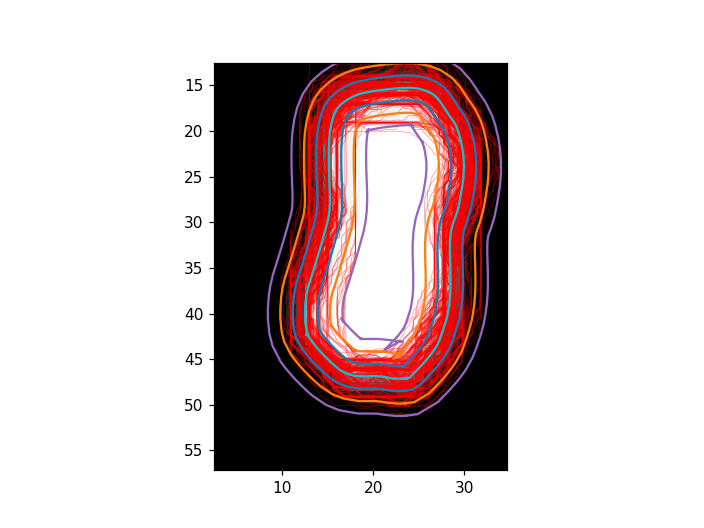

In [156]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.imshow(heat_map, cmap = 'gray')

# cont = interval_mean_target_contours[2][2]

# plt.plot( cont[0][:,1]*pixel_scaling - dimension_x_minus, cont[0][:,0]*pixel_scaling - dimension_y_minus)

#### Note: this heat map has pixel size = res_limit_pixel_size = 1.5mm, so a normalised vector in this heat map already has length 1.5mm

In [157]:
adapted_paths_to_heat_map = []


for breath_hold_number in range( 0 , number_of_breath_holds):
    
    #print(breath_hold_number)
    
    
    for interval_index in interval_indexs[breath_hold_number]:
        
        #print(averaging_time_interval_index)


        cont = interval_mean_target_contours[breath_hold_number][interval_index]

        adapted_paths_to_heat_map.append( path.Path(  [ [cont[0][i,1]*pixel_scaling - dimension_x_minus, cont[0][i,0]*pixel_scaling - dimension_y_minus ]  for i in range(0 , len(cont[0])) ] ))
        
        
    
import matplotlib.patches as patches 


for path_index in range( 0 , len(adapted_paths_to_heat_map)):

    patch = patches.PathPatch(adapted_paths_to_heat_map[path_index], lw=0.5 , ec = 'r' , fc = 'None' , alpha = 0.4)



    ax.add_patch(patch)







In [158]:
## Add mean  contour



heat_map_mean_contour = measure.find_contours(heat_map, 0.5)

heat_map_mean_contour_y_denoised = scipy.signal.savgol_filter(heat_map_mean_contour[0][:,0] , 3, 1, mode = 'wrap')

heat_map_mean_contour_y_denoised = np.concatenate( (heat_map_mean_contour_y_denoised, np.array([heat_map_mean_contour_y_denoised[0]])))


# heat_map_mean_contour_y_denoised = np.around(heat_map_mean_contour_y_denoised , 0)


heat_map_mean_contour_x_denoised = scipy.signal.savgol_filter(heat_map_mean_contour[0][:,1] , 3, 1, mode = 'wrap')

heat_map_mean_contour_x_denoised = np.concatenate( (heat_map_mean_contour_x_denoised, np.array([heat_map_mean_contour_x_denoised[0]])))


# heat_map_mean_contour_x_denoised = np.around(heat_map_mean_contour_x_denoised , 0) 



heat_map_mean_contour = np.array([ [heat_map_mean_contour_x_denoised[i] , heat_map_mean_contour_y_denoised[i] ] for i in range(0, len(heat_map_mean_contour_x_denoised))])


plt.plot(heat_map_mean_contour_x_denoised , heat_map_mean_contour_y_denoised , color = 'tab:cyan' )#, marker = '.')



# plt.scatter(heat_map_mean_contour_x_denoised[31] , heat_map_mean_contour_y_denoised[31] , color = 'r')
# plt.scatter(heat_map_mean_contour_x_denoised[32] , heat_map_mean_contour_y_denoised[32] , color = 'b')


# heat_map_90_contour = measure.find_contours(heat_map, 1 - 0.1)

# heat_map_90_contour_y_denoised = scipy.signal.savgol_filter(heat_map_90_contour[0][:,0] , 3, 1, mode = 'wrap')

# heat_map_90_contour_y_denoised = np.concatenate( (heat_map_90_contour_y_denoised, np.array([heat_map_90_contour_y_denoised[0]])))



# heat_map_90_contour_x_denoised = scipy.signal.savgol_filter(heat_map_90_contour[0][:,1] , 3, 1, mode = 'wrap')

# heat_map_90_contour_x_denoised = np.concatenate( (heat_map_90_contour_x_denoised, np.array([heat_map_90_contour_x_denoised[0]])))


# plt.plot(heat_map_90_contour_x_denoised , heat_map_90_contour_y_denoised , color = 'lime')#, marker = '.')

# plt.scatter(heat_map_90_contour_x_denoised[0] , heat_map_90_contour_y_denoised[0] , color = 'r' )
# plt.scatter(heat_map_90_contour_x_denoised[1] , heat_map_90_contour_y_denoised[1] , color = 'b')







# heat_map_10_contour = measure.find_contours(heat_map, 1 - 0.9)

# heat_map_10_contour_y_denoised = scipy.signal.savgol_filter(heat_map_10_contour[0][:,0] , 3, 1, mode = 'wrap')

# heat_map_10_contour_y_denoised = np.concatenate( (heat_map_10_contour_y_denoised, np.array([heat_map_10_contour_y_denoised[0]])))



# heat_map_10_contour_x_denoised = scipy.signal.savgol_filter(heat_map_10_contour[0][:,1] , 3, 1, mode = 'wrap')

# heat_map_10_contour_x_denoised = np.concatenate( (heat_map_10_contour_x_denoised, np.array([heat_map_10_contour_x_denoised[0]])))


# plt.plot(heat_map_10_contour_x_denoised, heat_map_10_contour_y_denoised , color = 'r')#, marker = '.')

# plt.scatter(heat_map_10_contour_x_denoised[0] , heat_map_10_contour_y_denoised[0] , color = 'r' )
# plt.scatter(heat_map_10_contour_x_denoised[1] , heat_map_10_contour_y_denoised[1] , color = 'b')



#### Now measure distance between contours

Set contours +- 1.5mm , +- 3mm , +-4.5mm from mean contour, count how many two sec contours are contained within  these

In [159]:
### Scaling of normal vectors to 1.5mm

norm_scaling = 1.5/min_resolvable_distance



normal_gradients = []

angles = []


contour_plus_1_pixel = []  #1.5mm

intersects_plus_1_pixel = []



contour_minus_1_pixel = []

intersects_minus_1_pixel = []



contour_plus_2_pixel = []  #3mm

intersects_plus_2_pixel = []




contour_minus_2_pixel = []

intersects_minus_2_pixel = []





contour_plus_3_pixel = []#4.5mm

intersects_plus_3_pixel = []


contour_minus_3_pixel = []

intersects_minus_3_pixel = []




number_of_paths = len(adapted_paths_to_heat_map)

print(number_of_paths)




for point_number in range(0, len(heat_map_mean_contour) - 1):

    delta_x = (heat_map_mean_contour_x_denoised[point_number + 1] - heat_map_mean_contour_x_denoised[point_number] )

    # print(delta_x)

    delta_y = (heat_map_mean_contour_y_denoised[point_number + 1] - heat_map_mean_contour_y_denoised[point_number] )

    # print(delta_y)


    mid_point = 0.5*(  np.array( [ heat_map_mean_contour_x_denoised[point_number] , heat_map_mean_contour_y_denoised[point_number] ]) + np.array( [ heat_map_mean_contour_x_denoised[point_number +1] , heat_map_mean_contour_y_denoised[point_number + 1] ]))


    # plt.scatter(mid_point[0] , mid_point[1])


    normal_gradient = (   1/(delta_x**2 + delta_y**2)**0.5)*np.array([delta_y , -delta_x])
    
    normal_gradients.append(normal_gradient)
    
    
    ### Angle defined from vertical (from cranial direction)
    
    
    cos_angle =  ( - normal_gradient[1]) /( ( normal_gradient[0]**2 + normal_gradient[1]**2 )**0.5)

    angle = np.arccos(cos_angle)
    
    if ( normal_gradient[0]) < 0:
        
        angle = 2*np.pi - angle 
    
    angles.append(angle)


    # plt.scatter(mid_point[0] + normal_gradient[0] , mid_point[1] + normal_gradient[1])
    
    
    
    
    #############################################################
    
    

    contour_plus_1_pixel.append( [mid_point[0] + norm_scaling*normal_gradient[0] , mid_point[1] + norm_scaling*normal_gradient[1] ] )
    
    
    
    ###### Count how many contours/paths inbetween these
    
    
    normal_end_points = np.array( [ mid_point , mid_point + norm_scaling*1*normal_gradient])


    normal_seg_path = path.Path(normal_end_points)
    
    
    
    
    
    intersect = 0
    
    
    for interval_contour_path in adapted_paths_to_heat_map:
        
        intersect += normal_seg_path.intersects_path( interval_contour_path , filled=False)
        
        
        
    intersects_plus_1_pixel.append(intersect/number_of_paths)  
    
    
    
            
            
    #############################################################
    
    

    contour_minus_1_pixel.append( [mid_point[0] - norm_scaling*normal_gradient[0] , mid_point[1] - norm_scaling*normal_gradient[1] ] )
    
    
    
    ###### Count how many contours/paths inbetween these
    
    
    normal_end_points = np.array( [ mid_point , mid_point - norm_scaling*1*normal_gradient])


    normal_seg_path = path.Path(normal_end_points)
    
    
    
    
    
    intersect = 0
    
    
    for interval_contour_path in adapted_paths_to_heat_map:
        
        intersect += normal_seg_path.intersects_path( interval_contour_path, filled=False)
        
        
        
    intersects_minus_1_pixel.append(intersect/number_of_paths)  
    
    
    
    
    
    
    #############################################################
    
    

    contour_plus_2_pixel.append( [mid_point[0] + norm_scaling*2*normal_gradient[0] , mid_point[1] + norm_scaling*2*normal_gradient[1] ] )
    
    
    
    ###### Count how many contours/paths inbetween these
    
    
    normal_end_points = np.array( [ mid_point , mid_point + norm_scaling*2*normal_gradient])


    normal_seg_path = path.Path(normal_end_points)
    
    
    
    
    
    intersect = 0
    
    
    for interval_contour_path in adapted_paths_to_heat_map:
        
        intersect += normal_seg_path.intersects_path( interval_contour_path, filled=False)
        
        
        
    intersects_plus_2_pixel.append(intersect/number_of_paths)  
    
        
            
        
    #############################################################
    
    

    contour_minus_2_pixel.append( [mid_point[0] - norm_scaling*2*normal_gradient[0] , mid_point[1] - norm_scaling*2*normal_gradient[1] ] )
    
    
    
    ###### Count how many contours/paths inbetween these
    
    
    normal_end_points = np.array( [ mid_point , mid_point - norm_scaling*2*normal_gradient])


    normal_seg_path = path.Path(normal_end_points)
    
    
    
    
    
    intersect = 0
    
    
    for interval_contour_path in adapted_paths_to_heat_map:
        
        intersect += normal_seg_path.intersects_path( interval_contour_path, filled=False)
        
        
        
    intersects_minus_2_pixel.append(intersect/number_of_paths)  
        
    
    
    #############################################################
    
    

    contour_plus_3_pixel.append( [mid_point[0] + norm_scaling*3*normal_gradient[0] , mid_point[1] + norm_scaling*3*normal_gradient[1] ] )
    
    
    
    ###### Count how many contours/paths inbetween these
    
    
    normal_end_points = np.array( [ mid_point , mid_point + norm_scaling*3*normal_gradient])


    normal_seg_path = path.Path(normal_end_points)
    
    
    
    
    
    intersect = 0
    
    
    for interval_contour_path in adapted_paths_to_heat_map:
        
        intersect += normal_seg_path.intersects_path( interval_contour_path, filled=False)
        
        
        
    intersects_plus_3_pixel.append(intersect/number_of_paths)  
    
            
    
    
    #############################################################
    
    

    contour_minus_3_pixel.append( [mid_point[0] - norm_scaling*3*normal_gradient[0] , mid_point[1] - norm_scaling*3*normal_gradient[1] ] )
    
    
    
    ###### Count how many contours/paths inbetween these
    
    
    normal_end_points = np.array( [ mid_point , mid_point - norm_scaling*3*normal_gradient])


    normal_seg_path = path.Path(normal_end_points)
    
    
    
    
    
    intersect = 0
    
    
    for interval_contour_path in adapted_paths_to_heat_map:
        
        intersect += normal_seg_path.intersects_path( interval_contour_path, filled=False)
        
        
        
    intersects_minus_3_pixel.append(intersect/number_of_paths)
    
    
    
    
            
        
    
    
    


    
    
                                 
                                 
contour_plus_1_pixel = np.array(contour_plus_1_pixel + [contour_plus_1_pixel[0]])

contour_minus_1_pixel = np.array(contour_minus_1_pixel + [contour_minus_1_pixel[0]])


contour_plus_2_pixel = np.array(contour_plus_2_pixel + [contour_plus_2_pixel[0]])

contour_minus_2_pixel = np.array(contour_minus_2_pixel + [contour_minus_2_pixel[0]])



contour_plus_3_pixel = np.array(contour_plus_3_pixel + [contour_plus_3_pixel[0]])

contour_minus_3_pixel = np.array(contour_minus_3_pixel + [contour_minus_3_pixel[0]])








within_1_pixel = np.array(intersects_minus_1_pixel) + np.array(intersects_plus_1_pixel)


within_2_pixel = np.array(intersects_minus_2_pixel) + np.array(intersects_plus_2_pixel)


within_3_pixel = np.array(intersects_minus_3_pixel) + np.array(intersects_plus_3_pixel)

                                                                 
                        
                                





plt.plot(contour_plus_1_pixel[:,0] , contour_plus_1_pixel[:,1] , color = 'tab:blue')

plt.plot(contour_minus_1_pixel[:,0] , contour_minus_1_pixel[:,1] , color = 'tab:blue' )
         
         
         
plt.plot(contour_plus_2_pixel[:,0] , contour_plus_2_pixel[:,1] , color = 'tab:orange')

plt.plot(contour_minus_2_pixel[:,0] , contour_minus_2_pixel[:,1] , color = 'tab:orange')

         
    
plt.plot(contour_plus_3_pixel[:,0] , contour_plus_3_pixel[:,1] , color = 'tab:purple')

plt.plot(contour_minus_3_pixel[:,0] , contour_minus_3_pixel[:,1] , color = 'tab:purple')




311


#### Smooth as function of angle (angle from -pi to pi)

139


<IPython.core.display.Javascript object>


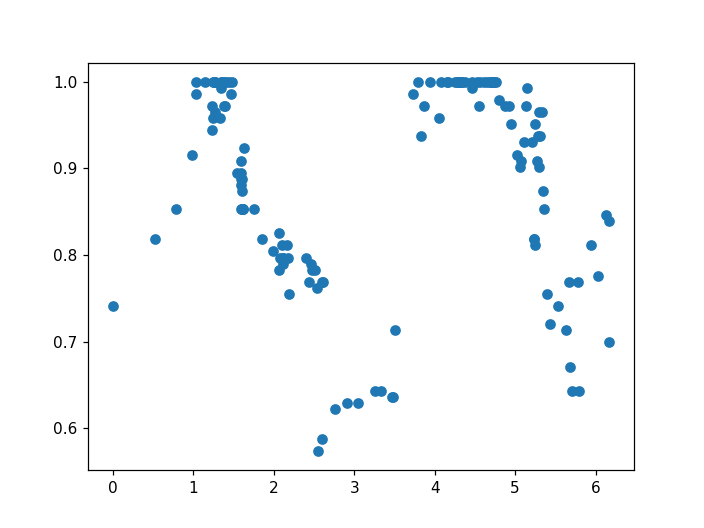

0.5
within 1.5mm median: 91.4 %
within 3mm median: 100.0 %
within 4.5mm median: 100.0 %
1.5
within 1.5mm median: 99.5 %
within 3mm median: 100.0 %
within 4.5mm median: 100.0 %
0.9546453546453546
1.0
1.0


In [138]:

angle_to_1_pixel = dict( zip(angles, within_1_pixel))

angle_to_2_pixel = dict( zip(angles, within_2_pixel))

angle_to_3_pixel = dict( zip(angles, within_3_pixel))



angles_sorted = np.array(sorted(angles) )





within_1_pixel_sorted = [ angle_to_1_pixel[angle] for angle in angles_sorted]

within_2_pixel_sorted = [ angle_to_2_pixel[angle] for angle in angles_sorted]

within_3_pixel_sorted = [ angle_to_3_pixel[angle] for angle in angles_sorted]


print(len(angles_sorted))



# angles_sorted_smoothed = scipy.signal.savgol_filter(angles_sorted, 21 , 3, mode = 'interp')

# within_1_pixel_sorted_smoothed = scipy.signal.savgol_filter( within_1_pixel_sorted ,21, 3, mode = 'wrap')

# within_2_pixel_sorted_smoothed = scipy.signal.savgol_filter( within_2_pixel_sorted, 21, 3, mode = 'wrap')

# within_3_pixel_sorted_smoothed = scipy.signal.savgol_filter( within_3_pixel_sorted , 21, 3, mode = 'wrap')


plt.figure()


#plt.plot( angles_sorted_smoothed , within_2_pixel_sorted_smoothed )

plt.scatter(angles_sorted , within_1_pixel_sorted , alpha = 1)




projection_angle = 1*np.pi/2




total_within_1_pixel = 0

total_within_2_pixel = 0

total_within_3_pixel = 0



for angle in [ projection_angle, (projection_angle + np.pi)%(2*np.pi)]:


    # angle = (projection_angle + np.pi)%(2*np.pi)

    print(angle/np.pi)


    local_angle_range = np.pi/16


    if (angle > local_angle_range ) & ( angle < 2*np.pi - local_angle_range):

        indexs = np.where( ( angles_sorted < angle + local_angle_range) & (angles_sorted > angle - local_angle_range) )[0]


    if angle < local_angle_range:


        indexs = list(np.where( (angles_sorted < angle + local_angle_range))[0] ) + list(  np.where(   (angles_sorted > 2*np.pi - local_angle_range + angle)  )[0])

        indexs = np.array(indexs)


    if 2*np.pi - angle < local_angle_range:

        indexs = list(  np.where(   angles_sorted  > angle - local_angle_range)[0] )  + list( np.where( angles_sorted < local_angle_range - (2*np.pi - angle))[0])

        indexs = np.array(indexs)







    angle_within_1_pixel = np.mean( [within_1_pixel_sorted[index] for index in indexs])
    
    total_within_1_pixel += angle_within_1_pixel

    print('within 1.5mm median: ' + str(   round(100*angle_within_1_pixel , 1) ) + ' %' )




    angle_within_2_pixel = np.mean( [within_2_pixel_sorted[index] for index in indexs])
    
    total_within_2_pixel += angle_within_2_pixel

    print('within 3mm median: ' + str(   round(100*angle_within_2_pixel , 1) ) + ' %' )



    angle_within_3_pixel = np.mean( [within_3_pixel_sorted[index] for index in indexs])
    
    total_within_3_pixel += angle_within_3_pixel

    print('within 4.5mm median: ' + str(   round(100*angle_within_3_pixel , 1) ) + ' %' )




    
    
print(total_within_1_pixel/2)  

print(total_within_2_pixel/2) 

print(total_within_3_pixel/2) 



In [137]:
2*180/np.pi

114.59155902616465

In [89]:
1.5/min_resolvable_distance

1.3636363636363635

[3.1343464036098996, 3.1368997963908236, 3.1465596128113185, 3.1512541887078482, 3.1742072042926743, 3.2676394931626342, 3.472565607910907, 3.6039317298296476, 3.6796842785030917, 3.702068168592472, 3.7492637553390087, 3.898208293898451, 3.921655358231984, 3.959126849442847, 3.9835444043202073, 3.995198433255675, 4.162216998042891, 4.309866055996892, 4.28672190916023, 4.2314893276824135, 4.150738102953893, 4.311664889670242, 4.298554471141023, 4.29420868750268, 4.383406862737492, 4.662860299729305, 4.770187213274142, 4.860651949174177, 4.832787024369823, 4.782726666939748, 4.746326562352717, 4.731492723679753, 4.724792543159296, 4.752334241137928, 4.986022422658138, 5.131789296877946, 5.342627491918602, 5.345547467239413, 5.30490929359218, 5.380109431285659, 5.392674978035884, 5.452219557276085, 5.446483424743676, 5.43104618798952, 5.4467123237493995, 5.406292227288499, 5.393086665258292, 5.479933315311969, 5.643318657980417, 5.7648788902569645, 6.125882281507119, 6.19838611861093, 6.1

<IPython.core.display.Javascript object>


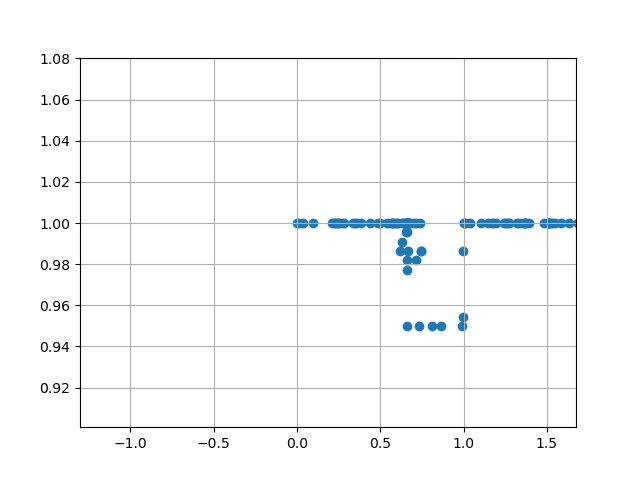

In [311]:

print(angles)

plt.figure()

plt.grid()

# plt.xlim(-1,1)

# plt.ylim(-1,1)

# plt.scatter(normal_gradients[72][0] , -normal_gradients[72][1])







plt.scatter( np.array(angles)/np.pi , np.array(intersects_minus_3_pixel) + np.array(intersects_plus_3_pixel)  )#, intersects_plus_1_pixel)

<IPython.core.display.Javascript object>


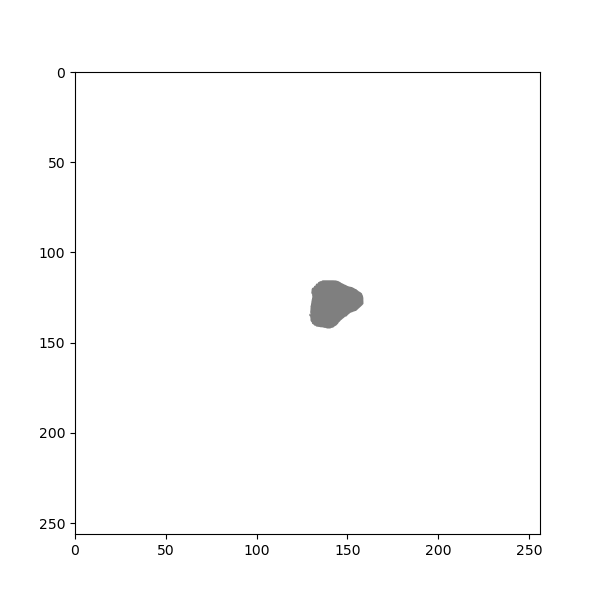

In [33]:
import matplotlib.patches as patches


fig = plt.figure(figsize = (6,6))

ax = fig.add_subplot(111)

plt.axis('on')

ax.set_xlim(0, 256)
ax.set_ylim(0, 256)

plt.gca().invert_yaxis()

patch = patches.PathPatch(interval_mean_target_paths[77], lw=0 , fc = (0,0,0))





shadow = patches.Shadow(patch, ox = 0, oy = 0 , fc = path_colours[68], alpha = 1)



ax.add_patch(shadow)



<IPython.core.display.Javascript object>


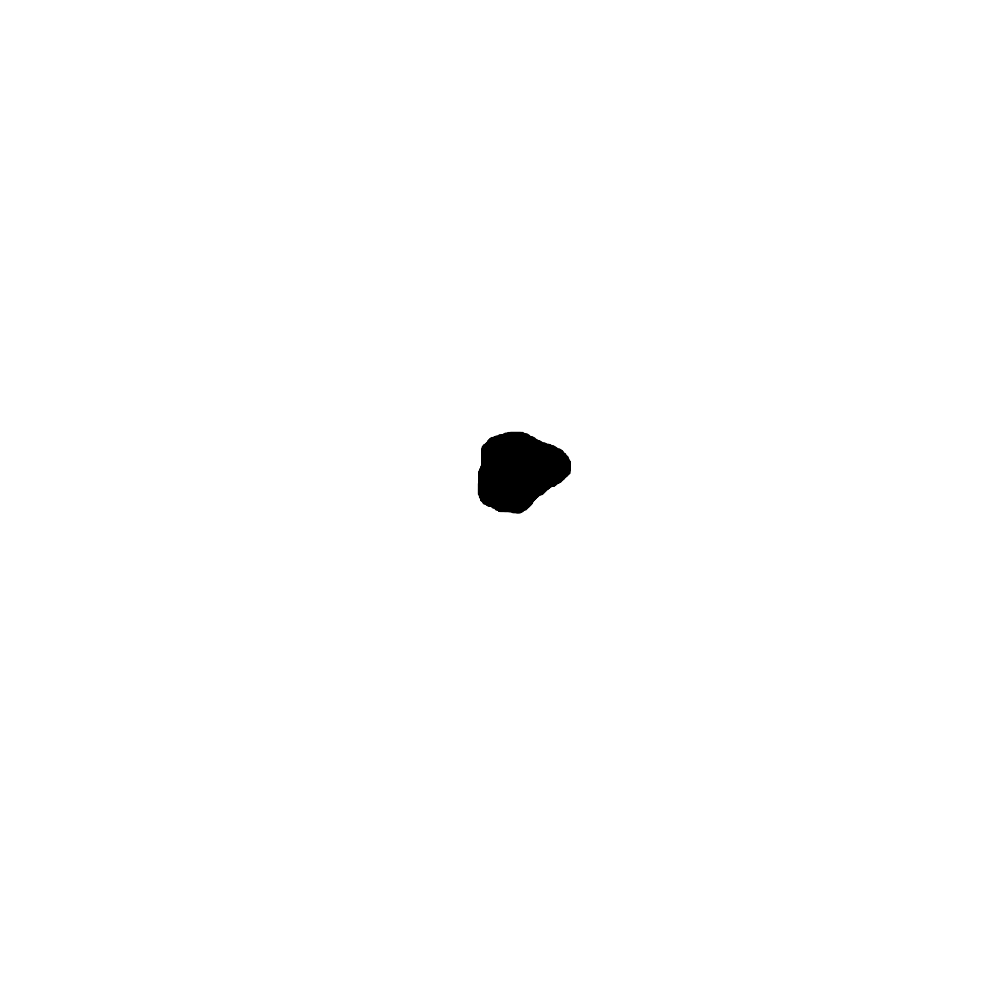

In [16]:
import matplotlib.patches as patches


fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(111)

plt.axis('off')




ax.set_xlim(0, 512)
ax.set_ylim(0, 512)

plt.gca().invert_yaxis()




#for interval_number in [0,1]:
    
for interval_number in range(0 , total_number_of_averaging_time_intervals):
    

    patch = patches.PathPatch(interval_mean_target_paths[interval_number], lw=0 , fc = (0,0,0))



    shadow = patches.Shadow(patch, ox = 0, oy = 0 , fc = 'black', alpha = 1)



    ax.add_patch(shadow)
    
    
    
    
    



    
#for cont in interval_mean_target_contours:


 #   plt.plot(cont[0][:,0] , cont[0][:,1],   linewidth =1 , color = 'red')


# test_path = path.Path(np.array([  [0, 0] , [0,512] , [512, 512], [512, 0] ]))

# test_patch = patches.PathPatch( test_path , ec = 'Red' , fc = 'none')

# ax.add_patch(test_patch)





#extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

#extent = ax.get_tightbbox(fig.canvas.renderer)

fig.set_size_inches(10, 10)


fig.savefig('bounding_region.png' , dpi = 200 , bbox_inches = 0, pad_inches=1)

#ax.savefig('fig.png' , dpi = 51.2, bbox_inches = 0 , pad_inches = 0)

<IPython.core.display.Javascript object>


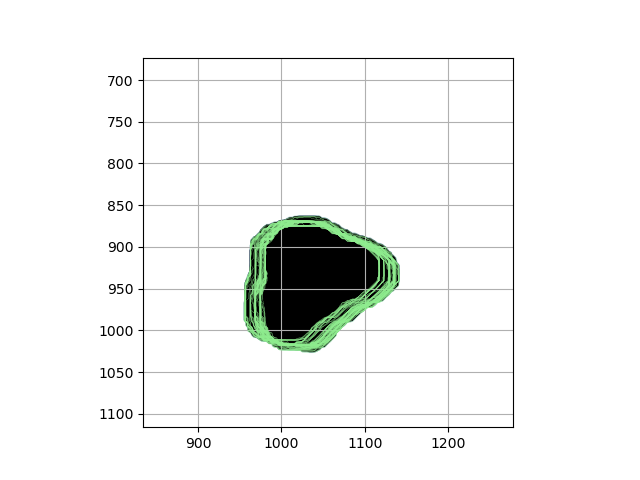

3.02734375
3.0078125


In [18]:
bounding_region_image = plt.imread('bounding_region.png')[:,:,0]

plt.figure()


plt.imshow(bounding_region_image , cmap = 'bone' , vmin = 0, vmax = 1)

plt.grid()



# pixel_min = np.amin(bounding_region_image)

# print(pixel_min)

# pixel_max = np.amax(bounding_region_image)

# print(pixel_max)


bounding_region_contour = measure.find_contours(bounding_region_image, 0.9 )


# bounding_region_contour_90 = measure.find_contours(bounding_region_image, 0.75*(pixel_max - pixel_min) + pixel_min )


# plt.plot( bounding_region_contour_90[0][:,1] , bounding_region_contour_90[0][:,0], marker = 'o')


# bounding_region_contour_10 = measure.find_contours(bounding_region_image, 0.25*(pixel_max - pixel_min) + pixel_min )


# plt.plot( bounding_region_contour_10[0][:,1] , bounding_region_contour_10[0][:,0], marker = 'o')



#Adapt interval contours for new coordinates system


x_scaling = (1799.5 - 249.5)/512

print(x_scaling)

y_scaling = (1779.5 - 239.5)/512

print(y_scaling)


#Adapted_interval_target_contours = [   np.array([   [ 249.5 + cont[0][i,0]*( (1799.5 - 249.5)/512  ) ,  239.5 + cont[0][i,1]*( (1779.5 - 239.5)/512  )   ]   for i in range(0, len(cont[0]))] ) for cont in interval_mean_target_contours]

Adapted_interval_target_contours = []




for breath_hold_number in range( 0 , number_of_breath_holds):
    
#for breath_hold_number in [1,3]:    
    
    for averaging_time_interval_index in interval_indexs[breath_hold_number]:
        
        cont = interval_mean_target_contours[breath_hold_number][averaging_time_interval_index]
        
        Adapted_interval_target_contours.append(
        
         np.array([   [ 249.5 + cont[0][i,0]*( (1799.5 - 249.5)/512  ) ,  239.5 + cont[0][i,1]*( (1779.5 - 239.5)/512  )   ]   for i in range(0, len(cont[0]))] ) ) 





#239.5 + cont[0][i,1]*( (1779.5 - 239.5)/512  ) 

#print(test.shape)

#for cont in interval_mean_target_contours:

#cont = interval_mean_target_contours[4]

    #plt.plot( 249.5 + cont[0][:,0]*( (1799.5 - 249.5)/512  )  , 239.5 + cont[0][:,1]*( (1779.5 - 239.5)/512  ) ,   linewidth =1 , color = 'red')
    

    
Adapted_interval_target_paths = []


    
for cont in Adapted_interval_target_contours:
    
    Adapted_interval_target_paths.append( path.Path(cont))
    
    plt.plot( cont[:,0] , cont[:,1] , color = 'lightgreen' , lw = 0.2)
    
    
    
    

    


#### Smoothing bounding contours

In [19]:
bounding_contour_y = bounding_region_contour[0][:,0]

bounding_contour_x = bounding_region_contour[0][:,1]



bounding_contour_y_denoised = scipy.signal.savgol_filter(bounding_contour_y, 29, 1 , mode = 'wrap')

bounding_contour_x_denoised = scipy.signal.savgol_filter(bounding_contour_x, 29, 1 , mode = 'wrap')


bounding_contour_denoised = np.array(list(zip(bounding_contour_x_denoised , bounding_contour_y_denoised)) )


bounding_contour_length = len(bounding_contour_denoised)

print(bounding_contour_length)

705


<IPython.core.display.Javascript object>


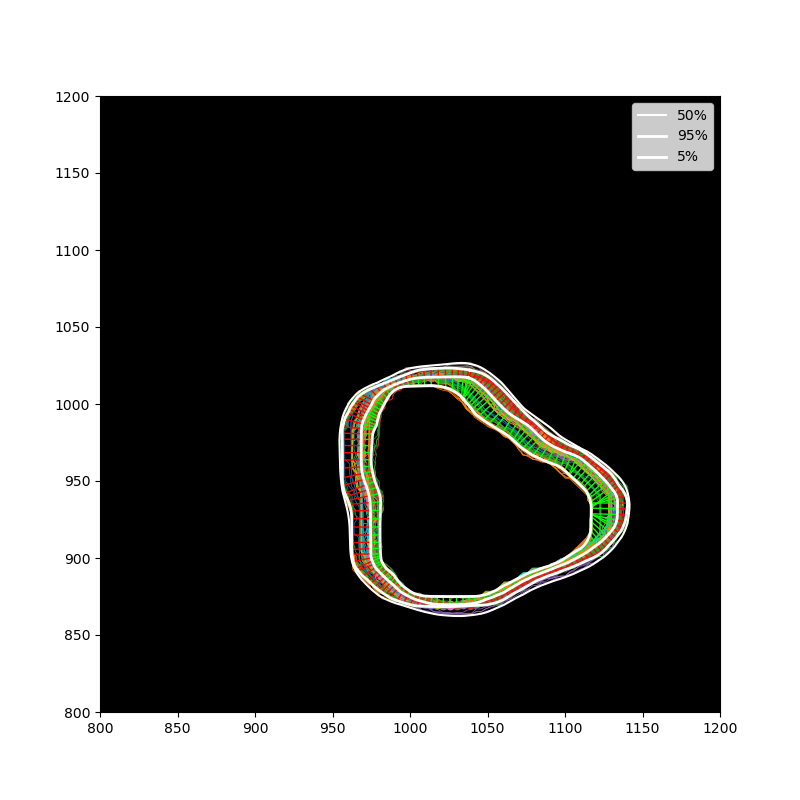

144


In [21]:
fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(111)

plt.axis('on')

#plt.grid()


ax.set_facecolor('black')



ax.set_xlim(800, 1200)
ax.set_ylim(800, 1200)

#plt.gca().invert_yaxis()


path_index = 0

for pathy in Adapted_interval_target_paths:
    
    


    patch = patches.PathPatch(pathy, lw=0.5 , ec = path_colours[path_index] , fc = 'None', alpha = 1)

    path_index += 1

    ax.add_patch(patch)
    
    
print(path_index)


#plt.axis('off')   
#ax.plot( bounding_region_contour[0][:,1] ,bounding_region_contour[0][:,0])

ax.plot( bounding_contour_denoised[:,0] , bounding_contour_denoised[:,1] , color = 'white')

#ax.scatter()
#ax.scatter( bounding_contour_denoised[76,0] , bounding_contour_denoised[76,1] , color = 'orange')

#bounding_region_contour_smoothed

#### Determining width of contour band


Extend a normal vector in from the bounding contour in increments, at each increment check if the normal vector intersects each interval contour. Use the lengths of the normal vector at which it intersects the contours to determine the width of the red band of contours. 


In [22]:
### Define normal vector  

fractional_point_distances = []


min_normal_lens = []

min_normal_points = []


max_normal_lens = []

max_normal_points = []


avg_normal_lens = []

avg_normal_points = []


widths = []




for point_number in np.arange(0, bounding_contour_length -1  ,5):
    
#for point_number in [100]:


    delta_y = (bounding_contour_y_denoised[point_number + 1] - bounding_contour_y_denoised[point_number] )

    #print(delta_y)

    delta_x = (bounding_contour_x_denoised[point_number + 1] - bounding_contour_x_denoised[point_number] )

    #print(delta_x)



    mid_point = 0.5*(  np.array( [ bounding_contour_x_denoised[point_number] , bounding_contour_y_denoised[point_number] ]) + np.array( [ bounding_contour_x_denoised[point_number +1] , bounding_contour_y_denoised[point_number + 1] ]))


    #ax.scatter( mid_point[0] , mid_point[1])

    #print( np.array( [ bounding_contour_x[point_number] , bounding_contour_y[point_number] ]))


    #print(mid_point)



    normal_gradient = (   1/(delta_x**2 + delta_y**2)**0.5)*np.array([delta_y , -delta_x])


    #print( ( ( normal_gradient[0]**2  + normal_gradient[1]**2)**0.5))



    fracs = []

    normal_lengths = []
    
    
    #print(point_number)
    
    
    frac = 0
    
    normal_length = 0
    
    #A while loop allows the iteration to be broken for either of these conditions, making code more efficient

    while (frac <= 0.95) & (normal_length <= 60):
        
        normal_lengths.append(normal_length)


        normal_end_points = np.array( [ mid_point , mid_point + normal_length*normal_gradient])


        normal_seg_path = path.Path(normal_end_points)


#         patch = patches.PathPatch(normal_seg_path, facecolor='lightblue', lw=2)

#         ax.add_patch(patch)


        frac = sum([ normal_seg_path.intersects_path( Adapted_interval_target_path) for Adapted_interval_target_path in Adapted_interval_target_paths]  )  / len(Adapted_interval_target_paths)
        
        
        fracs.append(frac)
        
        normal_length += 0.2
    
    
    
        
        
        
        

#     for normal_length in np.arange( 0, 50 , 0.2 ):
        
#         #print('yo ')


#         normal_lengths.append(normal_length)


#         normal_end_points = np.array( [ mid_point , mid_point + normal_length*normal_gradient])


#         normal_seg_path = path.Path(normal_end_points)


#         patch = patches.PathPatch(normal_seg_path, facecolor='lightblue', lw=2)

#         ax.add_patch(patch)


#         frac = sum([ normal_seg_path.intersects_path( Adapted_interval_target_path) for Adapted_interval_target_path in Adapted_interval_target_paths]  )  / len(Adapted_interval_target_paths)
#         print(frac)
#         fracs.append(frac)
        
    
    
    
        
    if normal_length <= 60:    #Sometimes the normal just won't ever intersect 95% of interval contours, so placing the cap at 
                                # length 50 prevents these from being counted
        
#         patch = patches.PathPatch(normal_seg_path, ec= 'lightgreen', lw=2)

#         ax.add_patch(patch)
   
        
        fractional_point_distances.append(  point_number/bounding_contour_length )
        
        

        min_normal_len_indx = np.where( np.array(fracs) > 0.05)[0][0] 

        min_normal_len = 0.5*( normal_lengths[min_normal_len_indx] + normal_lengths[min_normal_len_indx - 1])

        min_normal_lens.append(min_normal_len)
        
        min_normal_point = mid_point + min_normal_len*normal_gradient
        
        min_normal_points.append(min_normal_point)
        
        #ax.scatter(  min_normal_point[0], min_normal_point[1], color = 'tab:red')
        
        
        

        #print(min_normal_len)

        avg_normal_len_indx = np.where( np.array(fracs) > 0.5)[0][0]

        avg_normal_len = 0.5*( normal_lengths[avg_normal_len_indx] + normal_lengths[avg_normal_len_indx - 1])

        avg_normal_lens.append(avg_normal_len)
        
        avg_normal_point = mid_point + avg_normal_len*normal_gradient
        
        avg_normal_points.append(avg_normal_point)
        
        #ax.scatter(  avg_normal_point[0], avg_normal_point[1], color = 'tab:blue')


        max_normal_len_indx = np.where( np.array(fracs) > 0.95)[0][0]

        max_normal_len = 0.5*( normal_lengths[max_normal_len_indx] + normal_lengths[max_normal_len_indx - 1])

        max_normal_lens.append(max_normal_len)
        
        max_normal_point = mid_point + max_normal_len*normal_gradient
        
        max_normal_points.append(max_normal_point)
        
        #ax.scatter(  max_normal_point[0], max_normal_point[1], color = 'tab:green')


        widths.append( (max_normal_len - min_normal_len)*(1/3)*2.4*(MR_res/512)   ) 
        
    
#     else: 
        
#         patch = patches.PathPatch(normal_seg_path, ec= 'gray', lw=2)

#         ax.add_patch(patch)
        
        

avg_normal_points = np.array(avg_normal_points) 

min_normal_points = np.array(min_normal_points)

max_normal_points = np.array(max_normal_points)
        
        
# ax.scatter(  np.array(avg_normal_points)[:,0], np.array(avg_normal_points)[:,1], color = 'tab:blue' )#, marker = '.')


# ax.scatter(  np.array(min_normal_points)[:,0], np.array(min_normal_points)[:,1], color = 'tab:red')# , marker = '.')


# ax.scatter(  np.array(max_normal_points)[:,0], np.array(max_normal_points)[:,1], color = 'tab:green')# , marker = '.')

#### Smoothing new contours



In [23]:
avg_points_y = avg_normal_points[:,1]

avg_points_x = avg_normal_points[:,0]



avg_points_y_denoised = scipy.signal.savgol_filter(avg_points_y, 3, 1, mode = 'wrap')

avg_points_y_denoised = np.concatenate( (avg_points_y_denoised, np.array([avg_points_y_denoised[0]])))




avg_points_x_denoised = scipy.signal.savgol_filter(avg_points_x, 3, 1, mode = 'wrap' )

avg_points_x_denoised = np.concatenate( (avg_points_x_denoised, np.array([avg_points_x_denoised[0]])))


avg_points_denoised = np.array( list(zip(avg_points_x_denoised , avg_points_y_denoised)))


#ax.plot(avg_points_x_denoised, avg_points_y_denoised, color = 'tab:blue')




min_points_y = min_normal_points[:,1]

min_points_x = min_normal_points[:,0]



min_points_y_denoised = scipy.signal.savgol_filter(min_points_y, 3, 1, mode = 'wrap')

min_points_y_denoised = np.concatenate( (min_points_y_denoised, np.array([min_points_y_denoised[0]])))


min_points_x_denoised = scipy.signal.savgol_filter(min_points_x, 3, 1, mode = 'wrap')

min_points_x_denoised = np.concatenate( (min_points_x_denoised, np.array([min_points_x_denoised[0]])))


min_points_denoised = np.array( list(zip(min_points_x_denoised , min_points_y_denoised)))


#ax.plot(min_points_x_denoised, min_points_y_denoised, color = 'tab:red')





max_points_y = max_normal_points[:,1]

max_points_x = max_normal_points[:,0]



max_points_y_denoised = scipy.signal.savgol_filter(max_points_y, 3, 1, mode = 'wrap')

max_points_y_denoised = np.concatenate( (max_points_y_denoised, np.array([max_points_y_denoised[0]])))


max_points_x_denoised = scipy.signal.savgol_filter(max_points_x, 3, 1, mode = 'wrap')

max_points_x_denoised = np.concatenate( (max_points_x_denoised, np.array([max_points_x_denoised[0]])))

max_points_denoised = np.array( list(zip(max_points_x_denoised , max_points_y_denoised)))


#ax.plot(max_points_x_denoised, max_points_y_denoised, color = 'tab:green')


#### Interpolating between contour points

In [24]:
from scipy.interpolate import interp1d

In [25]:
x_avgs, y_avgs = avg_points_denoised.T

i = np.arange(len(avg_points_denoised[0::1]))

interp_i = np.linspace(0, i.max(), 2 * i.max())

xi = interp1d(i, x_avgs, kind='cubic')(interp_i)
yi = interp1d(i, y_avgs, kind='cubic')(interp_i)

avg_points_interpolated = np.array( list(zip(xi , yi)))

#ax.plot(xi,yi, color = 'tab:cyan' )

ax.plot(xi,yi, color = 'white' , lw = 2 )

# ax.scatter(xi[0],yi[0])#, color = 'tab:cyan' , lw = 2)#, marker = '*')

# ax.scatter(xi[1],yi[1])


x_mins, y_mins = min_points_denoised.T

j = np.arange(len(min_points_denoised[0::1]))

interp_j = np.linspace(0, j.max(), 2 * j.max())

xj = interp1d(j, x_mins, kind='cubic')(interp_j)
yj = interp1d(j, y_mins, kind='cubic')(interp_j)

min_points_interpolated = np.array( list(zip(xj , yj)))

#ax.plot(xj,yj, color = 'red' )#, marker = '*')

ax.plot(xj,yj, color = 'white' , lw = 2 )




x_maxs, y_maxs = max_points_denoised.T

k = np.arange(len(max_points_denoised[0::1]))

interp_k = np.linspace(0, k.max(), 2 * k.max())

xk = interp1d(k, x_maxs, kind='cubic')(interp_k)
yk = interp1d(k, y_maxs, kind='cubic')(interp_k)

max_points_interpolated = np.array( list(zip(xk , yk)))

#ax.plot(xk,yk, color = 'lime' )#, marker = '*')

ax.plot(xk,yk, color = 'white' , lw = 2 )


ax.legend(['50%' , '95%' , '5%'])


#### Create paths from 0.05 and 0.95 contours

In [26]:
contour_max = path.Path(max_points_interpolated )

contour_min = path.Path(min_points_interpolated )

#### Calculating distances  from 0.5 line

In [27]:
normal_gradients = []

distances_to_max = []

distances_to_min = []

fractions_around_contour = []



for point_number in np.arange( 0 , len(avg_points_interpolated) - 1 , 2):

#for point_number in np.arange( 120 , 122, 2):


    delta_y = (avg_points_interpolated[point_number + 1 , 1] - avg_points_interpolated[point_number , 1] )

    #print(delta_y)

    delta_x = (avg_points_interpolated[point_number + 1 , 0] - avg_points_interpolated[point_number , 0] )

    #print(delta_x)



    mid_point = 0.5*( avg_points_interpolated[point_number + 1] + avg_points_interpolated[point_number] )

    ax.scatter( mid_point[0] , mid_point[1])

    #print( np.array( [ bounding_contour_x[point_number] , bounding_contour_y[point_number] ]))


    #print(mid_point)



    normal_gradient_in = (   1/(delta_x**2 + delta_y**2)**0.5)*np.array([delta_y , -delta_x])

    
    
    
    
    
    normal_length_in = 0
    
    intersects_bool_max = 0
    
    
    while (intersects_bool_max == 0) & ( normal_length_in <= 30):
    
        normal_end_points_in = np.array( [ mid_point , mid_point + normal_length_in*normal_gradient_in])


        normal_seg_path_in = path.Path(normal_end_points_in)
        
    
        intersects_bool_max = normal_seg_path_in.intersects_path( contour_max)
        
        normal_length_in += 0.1

    
    
#     if normal_length_in < 20:
        
        
#         distances_to_max.append(normal_length_in)
    
#         normal_line_to_max = patches.PathPatch(normal_seg_path, ec= 'lime', lw=2)

#         ax.add_patch(normal_line_to_max)

    
    
    
    
    normal_length_out = 0
    
    intersects_bool_min = 0
    
    
    normal_gradient_out = (   1/(delta_x**2 + delta_y**2)**0.5)*np.array([-delta_y , delta_x])
    
    normal_gradients.append(normal_gradient_out)
    
    
    while (intersects_bool_min == 0) & ( normal_length_out <= 30):
        
    
        normal_end_points_out = np.array( [ mid_point , mid_point + normal_length_out*normal_gradient_out])


        normal_seg_path_out = path.Path(normal_end_points_out)
        
    
        intersects_bool_min = normal_seg_path_out.intersects_path( contour_min , filled = 0)
        
        #print(intersects_bool_min)
        
        normal_length_out += 0.1

        
        
    if (normal_length_out < 30) & (normal_length_in < 30):
        
        
        distances_to_min.append(normal_length_out)
    
        normal_line_to_min = patches.PathPatch(normal_seg_path_out, ec= 'red', lw=1)

        ax.add_patch(normal_line_to_min)
        
        
        distances_to_max.append(normal_length_in)
        
        normal_line_to_max = patches.PathPatch(normal_seg_path_in, ec= 'lime', lw=1)

        ax.add_patch(normal_line_to_max)
        
        
        
        fractions_around_contour.append( point_number / len(avg_points_interpolated))



distances_to_min = np.array(distances_to_min)

distances_to_max = np.array(distances_to_max)

fractions_around_contour = np.array(fractions_around_contour)
    


<IPython.core.display.Javascript object>


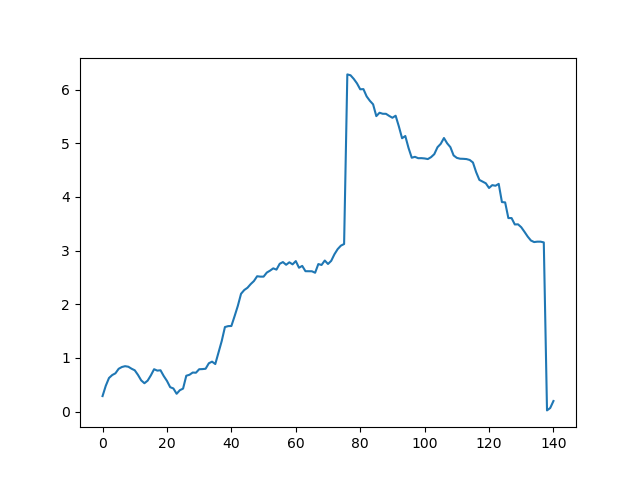

In [28]:
#print(normal_gradients)

angles = []


#print(normal_gradients)

for normal_gradient in normal_gradients:
    
    cos_angle = (normal_gradient[1]) / ( (   normal_gradient[1]**2 + normal_gradient[0]**2 )**(1/2) )

    angle = np.arccos(cos_angle)

    if normal_gradient[0] < 0:

        angle = np.pi + angle

    angles.append(angle)
    

plt.figure()    
    
plt.plot(angles)



<IPython.core.display.Javascript object>


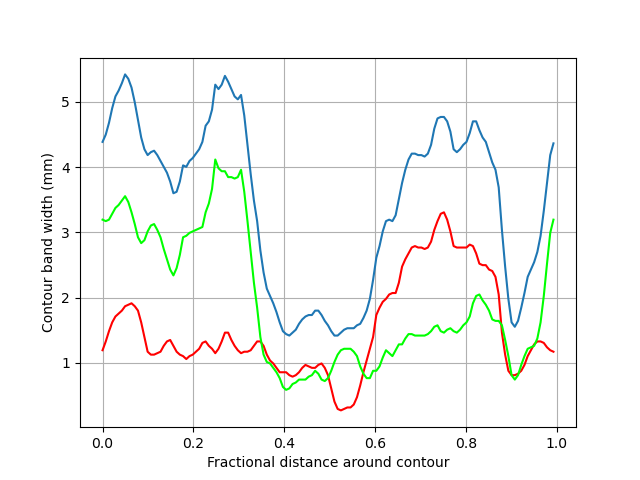

3.4573404255319096
1.296957508065499


In [29]:
plt.figure()


plt.grid()


plt.plot( fractions_around_contour,  distances_to_min*(1/3)*(MR_res/cine_res)*MR_pixel , color = 'red')

plt.plot( fractions_around_contour,  distances_to_max*(1/3)*(MR_res/cine_res)*MR_pixel , color = 'lime')

plt.plot( fractions_around_contour,  (distances_to_max + distances_to_min)*(1/3)*(MR_res/cine_res)*MR_pixel)

plt.ylabel('Contour band width (mm)')
plt.xlabel('Fractional distance around contour')



breath_hold_margin_mean = np.mean( (distances_to_max + distances_to_min)*(1/3)*(MR_res/cine_res)*MR_pixel )

print(breath_hold_margin_mean)


breath_hold_margin_std = np.std( (distances_to_max + distances_to_min)*(1/3)*(MR_res/cine_res)*MR_pixel )

print(breath_hold_margin_std)



breath_hold_margins_raw = [ (distances_to_max + distances_to_min)*(1/3)*(MR_res/cine_res)*MR_pixel ,  fractions_around_contour]

breath_hold_margin_data = [ breath_hold_margin_mean, breath_hold_margin_std ]


with open('Cine Pickles/' + cine_video_name + '/Analysising Breath-holds/breath_hold_margin_data.pickle', 'wb') as handle:
    pickle.dump(breath_hold_margin_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

with open('Cine Pickles/' + cine_video_name + '/Analysising Breath-holds/breath_hold_margins_raw.pickle', 'wb') as handle:
    pickle.dump(breath_hold_margins_raw, handle, protocol=pickle.HIGHEST_PROTOCOL)

1.880880281690139
0.2428489933165258


<IPython.core.display.Javascript object>


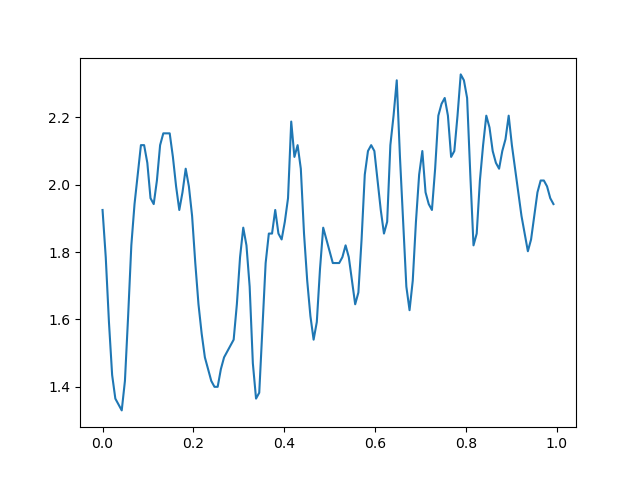

In [97]:
with open('Cine Pickles/' + cine_video_name + '/Analysising Breath-holds/breath_hold_margin_data.pickle', 'rb') as handle:
    breath_hold_margin_data = pickle.load(handle)
    
    
print(breath_hold_margin_data[0])

print(breath_hold_margin_data[1])


with open('Cine Pickles/' + cine_video_name + '/Analysising Breath-holds/breath_hold_margins_raw.pickle', 'rb') as handle:
    breath_hold_margins_raw = pickle.load(handle)
    
    
plt.figure()

plt.plot( breath_hold_margins_raw[1] , breath_hold_margins_raw[0] )

<IPython.core.display.Javascript object>


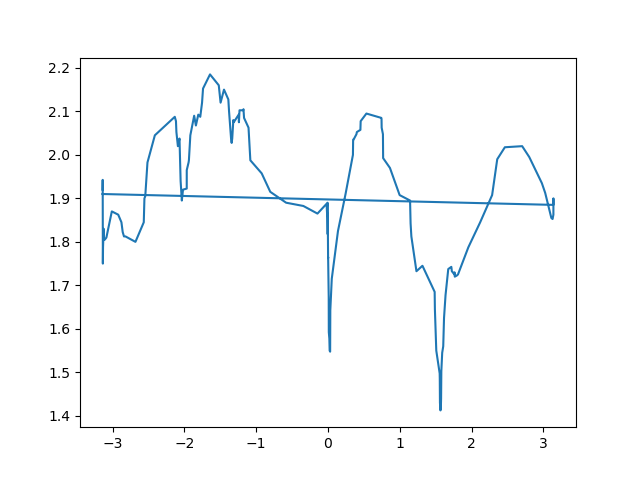

In [98]:
widths_90 = (distances_to_max + distances_to_min)*(1/3)*(MR_res/cine_res)*MR_pixel




angles_2_width_dict = dict( zip( angles, widths_90))

angles_sorted = sorted(angles)

widths_90_sorted = [ angles_2_width_dict[angle] for angle in angles_sorted]




list_widths_sorted = list(widths_90_sorted)

widths_90_sorted = np.array( list_widths_sorted + [widths_90_sorted[0]] )


angles_sorted = angles_sorted + [angles_sorted[0]]



widths_90_sorted_smoothed = scipy.signal.savgol_filter(widths_90_sorted, 7, 1, mode = 'wrap')





fig, ax = plt.subplots()#subplot_kw={'projection': 'polar'})

#ax.set_theta_zero_location("N")

#ax.plot(angles_sorted , widths_90_sorted)

ax.plot(angles_sorted , widths_90_sorted_smoothed)

<IPython.core.display.Javascript object>


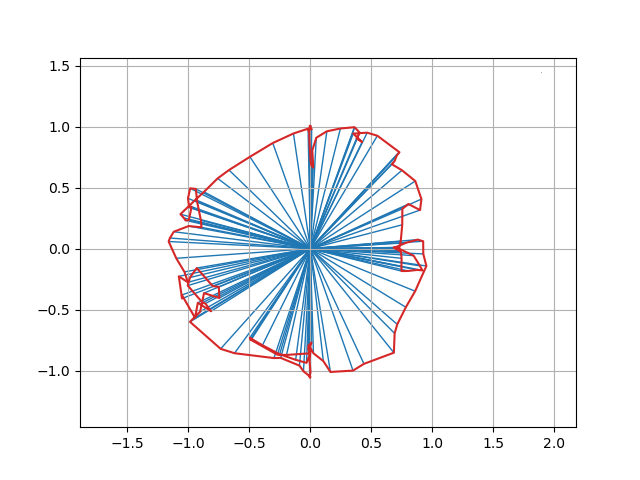

In [99]:
figgy = plt.figure()

axxy = figgy.add_subplot(111)


axxy.set_xlim(-6, 6)
axxy.set_ylim(-6, 6)

plt.grid()


normal_vectors = [  0.5*( (distances_to_max[i] + distances_to_min[i])*(1/3)*(MR_res/cine_res)*MR_pixel  )*normal_gradients[i] for i in range(0, len(normal_gradients)) ]           

normal_vector_paths = [ path.Path( [ normal_vector , [0,0] ] ) for normal_vector in normal_vectors ]

normal_vector_patchs = [ patches.PathPatch( normal_vector_path , ec = 'tab:blue') for normal_vector_path in normal_vector_paths ]

add_patches = [ axxy.add_patch(normal_vector_patch) for normal_vector_patch in normal_vector_patchs]

plt.plot( np.array(normal_vectors)[:,0],  np.array(normal_vectors)[:,1] , color = 'tab:red')

see at what lengths of normal vector that frac = 0.05 and frac = 0.95, these points define pointsa on the 5% and 95% contours.

Interpolate between all of these points to better define 95 and 5 contours, calculate distances between these two contours.

<IPython.core.display.Javascript object>


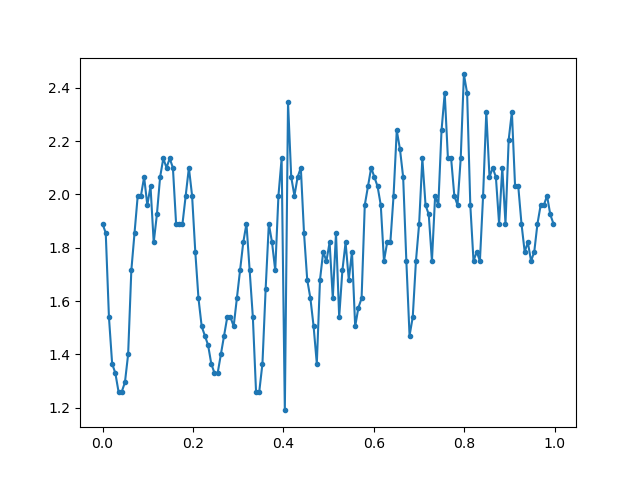

In [100]:
plt.figure()


#plt.scatter( np.array(normal_lengths) , fracs , marker = '.')

# plt.plot( fractional_point_distances, (np.array(avg_normal_lens) - np.array(min_normal_lens))*(1/3)*(144/512)*2.4 )

# plt.plot( fractional_point_distances, (np.array(max_normal_lens) - np.array(avg_normal_lens))*(1/3)*(144/512)*2.4 )

plt.plot(fractional_point_distances , widths , marker = '.')

In [ ]:
plt.figure()

plt.grid()

plt.plot( np.arange(0, bounding_contour_length ,25) , widths , marker = '.')


plt.plot(np.arange(0, bounding_contour_length ,25) , [np.mean(widths) for p in np.arange(0, bounding_contour_length ,25)])

#plt.plot()

In [98]:
min_normal_len_indx = np.where( np.array(fracs) > 0.05)[0][0] 

min_normal_len = 0.5*( normal_lengths[min_normal_len_indx] + normal_lengths[min_normal_len_indx - 1])

print(min_normal_len)

max_normal_len_indx = np.where( np.array(fracs) > 0.95)[0][0]

max_normal_len = 0.5*( normal_lengths[max_normal_len_indx] + normal_lengths[max_normal_len_indx - 1])


print(max_normal_len)


print((max_normal_len - min_normal_len)**(1/3)*2.4*(144/512))



1.7000000000000002
12.100000000000001
1.4733803921324928
